### Input Sample

**250W**

### 初始

In [41]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import pandas as pd
import time
from datetime import datetime
from datetime import timedelta
import numpy as np
import itertools
import os
sns.set_style('whitegrid',{'font.sans-serif':['simhei','Arial']})
import warnings
import collections
warnings.simplefilter('ignore', np.RankWarning)

class IntervalGenerator(object):
    def __init__(self, first_date, days=3):
        self.days = days
        self.first_date = datetime.fromtimestamp(first_date)
        self.begin_interval = -1
        self.end_interval = -1

    def daysGenerator(self):
        for i in range(self.days + 1):
            num_of_days = timedelta(i)
            interval = self.first_date + num_of_days
            during_secs = interval.second + 60 * interval.minute + interval.hour * 3600
            self.begin_interval = interval.timestamp() - during_secs
            self.end_interval = interval.timestamp() + (86400 - during_secs)
            yield self

    def hoursGenerator(self):
        num_of_hours = (self.days + 1) * 24
        for i in range(num_of_hours):
            first_date_timestamp = self.first_date.timestamp()
            # during_secs = interval.second + 60 * interval.minute + interval.hour * 3600
            self.begin_interval = first_date_timestamp + i*3600
            self.end_interval = first_date_timestamp + (i+1)*3600
            yield self

    def clearInterval(self):
        self.begin_interval = -1
        self.end_interval = -1
        
## 分离了 database 的管理
import sqlite3
import pandas as pd
import numpy as np
import collections
import time
from datetime import datetime
from datetime import timedelta

class DatabaseManager(object):
    def __init__(self, db):
        self.conn = sqlite3.connect(db)
        self.cur = self.conn.cursor()

    def query(self, arg):
        self.cur.execute(arg)
        return self.cur

    def __del__(self):
        self.conn.close()


def dataGen(db, query):
    dbms = DatabaseManager(db)
    for row in dbms.query(query):
        yield row

## 分离比较ACTION的逻辑
def compareAction(user_action, action_list):

    if user_action in action_list:
        return True
    else:
        return False

In [3]:
db = "/home/maoan/maidianAnalysis/level2-uianalysis/world_seven.db"
db2 = "/home/maoan/maidianAnalysis/xiamen/xiamen_1.db"
db3= "/home/maoan/maidianAnalysis/xiamen/1308310007.db"
db4 = "/home/maoan/maidianAnalysis/xiamen/xiamen_1b.db"
new_date = datetime.strptime("2017-05-18", "%Y-%m-%d")

In [3]:
conn = sqlite3.connect(db4)
sqlstr_action_list = "SELECT yonghu_id,timestamp,action,vip_level FROM maidian ORDER BY yonghu_id,timestamp ASC;"


In [9]:
data_iterator = dataGen(db4,sqlstr_action_list)

total_index_dict = collections.defaultdict(list)
alist = []
flist = []
counter = 0
current_player = -1 
a_len = 0
max_len =[]
flag_vip = False

for row in data_iterator:
    counter += 1
    if counter % 1000000 == 0:
            print("%s lines processed\n" % counter)
            # print("total enter:" + str(num_enter))
            # print("correct exit :" + str(num_of_correct_exit))

    player_id = row[0]
    action = row[2]
    timestamp = row[1]
    level = row[3]
        
    if player_id != current_player:

        find_flag = False
        window_len = 0

        if current_player != -1 and flag_vip:
            max_len.append(a_len)
#             total_index_dict[current_player] = [alist,flist]
        current_player = player_id                
        alist = []
        flist = []
        a_len = 0
        flag_vip = False 
        
    if level == 0:
        flist.append(0)
        a_len += 1
    else:
        flag_vip = True
        flist.append(1)
        
#     alist.append(action)

total_index_dict[current_player] = [alist,flist]
temp = pd.DataFrame(list(total_index_dict.items()), columns=['Player', 'KeyFactor'])


1000000 lines processed

2000000 lines processed

3000000 lines processed

4000000 lines processed

5000000 lines processed

6000000 lines processed

7000000 lines processed

8000000 lines processed



In [10]:
max(max_len)

6285

### 单人数据下载

In [138]:
# db= "/home/maoan/maidianAnalysis/level2-uianalysis/world_seven.db"
conn = sqlite3.connect(db4)

dbcol = pd.read_sql("SELECT * FROM maidian LIMIT 2;", conn)
#uidata = pd.read_sql("SELECT player_id,action,major_class,subject_class,minor_class,happen_time FROM maidian ORDER BY player_id,happen_time ASC;", conn)

#features = "happen_time, player_id, player_level, peerage, gold, silver, food, wood, iron, exploit, hero_power, building_power, army_power, peerage_power, territory_power, total_power"

feature = "vip_level"

# sqlstr = "SELECT happen_time, player_id, major_class, action, " + feature + " FROM maidian ORDER BY player_id,happen_time ASC;"
sqlstr_single = "SELECT yonghu_id, wanjia_id, timestamp, action FROM maidian WHERE yonghu_id = 37902 ORDER BY yonghu_id,timestamp ASC;"
sqlstr_all = "SELECT yonghu_id," + feature + ", num_days_played FROM maidian ORDER BY yonghu_id,timestamp ASC;"

# sqlstr = "SELECT action FROM maidian;"
# keyIndexData = pd.read_sql_query(sqlstr, conn)
singleuserData = pd.read_sql_query(sqlstr_single, conn)
singleuserData.to_csv("单用户信息-M.csv", index=False)
keyIndexData = pd.read_sql_query(sqlstr_all, conn)

In [88]:
dbcol['hero_info']

0    12032501020000
1    12032501020000
Name: hero_info, dtype: object

In [4]:
dbcol['vip_level']

0    0
1    0
Name: vip_level, dtype: int64

In [46]:
keyIndexData['vip'] = keyIndexData['vip_level'] >=1

### 动作分布

In [216]:
def ActionDistribution(db,sqlstr):

    # sqlstr = "SELECT yonghu_id, " + index + ", timestamp, action FROM maidian ORDER BY yonghu_id,timestamp ASC;"
#     sqlstr = "SELECT " + user_id + ", " + index + ", "+timestamp + ", " + action +" FROM maidian ORDER BY " +user_id+","+timestamp+ " ASC;"
    data_iterator = dataGen(db, sqlstr)

    current_player = -1
    first_action_time = -1
    last_action_time = -1
    last_key_value = -1
    one_block_time = 0
    num_growth = 0
    one_interval_clicks_list = 0
    time_limit = 300

    total_index_dict = collections.defaultdict(list)
    action_contribution_dict = collections.defaultdict(int)
    player_list = []
    starting_time = time.time()
    counter = 0
    # dist = collections.defaultdict(int)

    for row in data_iterator:
        counter += 1
        if counter % 1000000 == 0:
            print("%s lines processed\n" % counter)
            # print(timestamp)

        player_id = row[0]
        timestamp = row[1]
        action = row[2]
        vip = row[3]
        # 如果更换用户，初始化所有值
        if player_id != current_player:

            temp_list = []
            for k, v in action_contribution_dict.items():
                temp_list.append([k, v])

#             player_list.append(temp_list)

            if current_player != -1:
                total_index_dict[current_player] = temp_list

            action_contribution_dict.clear()
            player_list = []
            current_player = player_id
        
        if vip >= 1:
            continue 
        
        action_contribution_dict[action] += 1
        
    temp = pd.DataFrame(list(total_index_dict.items()), columns=['Player', 'KeyFactor'])
    
    return temp

In [217]:
sqlstr="SELECT yonghu_id, timestamp, action, vip_level FROM maidian ORDER BY yonghu_id,timestamp ASC;"
res = ActionDistribution(db4,sqlstr)

1000000 lines processed

2000000 lines processed

3000000 lines processed

4000000 lines processed

5000000 lines processed

6000000 lines processed

7000000 lines processed

8000000 lines processed



In [218]:
res

,Player,KeyFactor
0,1039,[[UIRoot2D/NormalPanel/ServerShowWin/Btn_Start...
1,1263,[[UIRoot2D/NormalPanel/OPShowWin/Go_OPShow/Btn...
2,2985,[[UIRoot2D/NormalPanel/OPShowWin/Go_OPShow/Btn...
3,4421,[[UIRoot2D/NormalPanel/OPShowWin/Go_OPShow/Btn...
4,6316,[[UIRoot2D/NormalPanel/OPShowWin/Go_OPShow/Btn...
5,6435,"[[UIRoot2D/ModalPanel/StoryModeNewWin, 173], [..."
6,8165,[[UIRoot2D/NormalPanel/OPShowWin/Go_OPShow/Btn...
7,8614,[[UIRoot2D/NormalPanel/OPShowWin/Go_OPShow/Btn...
8,8857,[[UIRoot2D/NormalPanel/OPShowWin/Go_OPShow/Btn...
9,10532,[[UIRoot2D/NormalPanel/OPShowWin/Go_OPShow/Btn...


In [39]:
res['KeyFactor'][0]

[['UIRoot2D/NormalPanel/ServerShowWin/Btn_StartGame', 6],
 ['UIRoot2D/NormalPanel/NoviceChargenWin/Go_NoviceChargen/Go_PlayerName/Ipf_Account',
  1],
 ['UIRoot2D/NormalPanel/NoviceChargenWin/Go_NoviceChargen/Btn_Confirm', 1],
 ['UIRoot2D/NormalPanel/OPShowWin/Go_OPShow/Btn_Skip', 1],
 ['UIRoot2D/ModalPanel/StoryModeNewWin', 5],
 ['UIRoot2D/ModalPanel/StoryModeNewWin/Go_StoryMode/Go_WinMask/Btn_Back', 3],
 ['UIRoot2D/TipsPanel/TeamLevelUPWin/Go_Win/Btn_Click', 1],
 ['UIRoot2D/NormalPanel/BattleSettlementWin/Img_Bg/Go_Btn/Btn_Quit', 1],
 ['UIRoot2D/NormalPanel/MainWin/Go_Menu/Msk_DisplayArea/Grid/Btn_Hero', 3],
 ['UIRoot2D/NormalPanel/HeroListWin/Panel_HeroList/ScrollRect/Go_Content/Hero_InfiniteItem_01/Content/HeroListItem01',
  3],
 ['UIRoot2D/NewGuidePanel/Tog_Hero', 1],
 ['UIRoot2D/NormalPanel/HeroInfoWin/Go_ToggleList/Tog_Hero', 2],
 ['UIRoot2D/NormalPanel/RunePromoteWin/Go_RunePromote/Go_Rune/Btn_RuneRankInfo',
  2],
 ['UIRoot2D/NormalPanel/RunePromoteWin/Go_RunePromote/Go_Rune/Go_

In [32]:
temp

dict_keys(['UIRoot2D/NormalPanel/OPShowWin/Go_OPShow/Btn_Skip'])

In [42]:
c = collections.Counter({ ele[0]:ele[1] for ele in res['KeyFactor'][0]})  

In [69]:
test = {'a':3,'b':4,'c':5}

In [71]:
test.keys()

dict_keys(['a', 'b', 'c'])

In [72]:
total_counter = collections.Counter()
total_dist = collections.defaultdict(list)

In [73]:
def merge_counter(x):
    temp = {ele[0]:ele[1] for ele in x}
    for key in temp.keys():
        total_dist[key].append(temp[key])

In [155]:
vip = keyIndexData.groupby('yonghu_id').apply(lambda x : (x['vip_level'].tail(1) != 0).values).apply(lambda x: x[0]).reset_index(name="vip")

In [238]:
non_vip_stay_users = res.loc[nonliush['stay'],].loc[~vip['vip'],'KeyFactor']
vip_stay_users = res.loc[nonliush['stay'],].loc[vip['vip'],'KeyFactor']

In [252]:
stay_users = res.loc[nonliush['stay'],'KeyFactor']

In [239]:
total_counter = collections.Counter()
total_dist = collections.defaultdict(list)
vip_stay_users.apply(lambda x: merge_counter(x))
vip_c = collections.Counter({k:np.median(total_dist[k]) for k in total_dist.keys()})
vip_top_actions = [ele[0] for ele in vip_c.most_common(20)]

total_dist = collections.defaultdict(list)
non_vip_stay_users.apply(lambda x: merge_counter(x))
non_vip_c = collections.Counter({k:np.median(total_dist[k]) for k in total_dist.keys()})
non_vip_top_actions = [ele[0] for ele in non_vip_c.most_common(20)]

In [253]:
total_dist = collections.defaultdict(list)
stay_users.apply(lambda x: merge_counter(x))
diff_action = collections.Counter({k:np.std(total_dist[k]) for k in total_dist.keys()})

In [275]:
','.join([ele[0] for ele in diff_action.most_common(10)])

'UIRoot2D/NormalPanel/BossInvadeBattleWin/Go_HeroSkill/Btn_CommonAttack,UIRoot2D/NormalPanel/DuelistBattleWin/Go_HeroSkill/Btn_CommonAttack,UIRoot2D/NormalPanel/EquipStrengthenWin/Go_Strengthen/Btn_strengthen,UIRoot2D/ModalPanel/StoryModeNewWin,UIRoot2D/NormalPanel/HeroAttributeWin/Go_HeroAttribute/Go_ScrollList/Go_List/Go_AttributeTip/Go_ItemList/Go_Item_0,UIRoot2D/NormalPanel/HeroSkillTrainWin/Go_SkillTrain/Go_RageSkill/Go_Upgrade/Btn_Upgrade,UIRoot2D/NormalPanel/HeroSkillTrainWin/Go_SkillTrain/Go_BasicSkill/Go_MobaSkill1/Btn_Upgrade,UIRoot2D/NormalPanel/HeroSkillTrainWin/Go_SkillTrain/Go_BasicSkill/Go_MobaSkill2/Btn_Upgrade,UIRoot2D/NormalPanel/FriendListWin/Go_FriendItem/Go_FriendPanel/Go_FriendList/Go_Content/Friend_01/Go_FriendItem_For_FriendListWin/Go_BtnAdd/Btn_Add,UIRoot2D/NormalPanel/UGCBattleWin/Go_PlayerCard/Go_UGCBattleCard_1'

/home/maoan/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


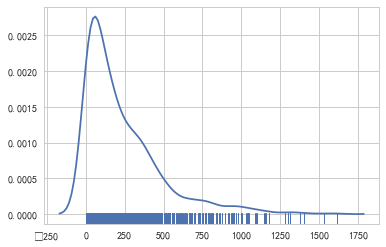

In [268]:
# sns.distplot(total_dist['UIRoot2D/NormalPanel/EquipStrengthenWin/Go_Strengthen/Btn_strengthen'], hist=False, rug=True)
sns.distplot(total_dist['UIRoot2D/NormalPanel/BossInvadeBattleWin/Go_HeroSkill/Btn_CommonAttack'], hist=False, rug=True)


In [267]:
np.mean(total_dist['UIRoot2D/NormalPanel/BossInvadeBattleWin/Go_HeroSkill/Btn_CommonAttack'])

234.80670611439842

In [242]:
non_vip_c.most_common(20)

[('UIRoot2D/NormalPanel/BossInvadeBattleWin/Go_HeroSkill/Btn_CommonAttack',
  116.5),
 ('UIRoot2D/NormalPanel/HeroSkillTrainWin/Go_SkillTrain/Go_BasicSkill/Go_MobaSkill2/Btn_Upgrade',
  70.0),
 ('UIRoot2D/NormalPanel/HeroSkillTrainWin/Go_SkillTrain/Go_BasicSkill/Go_MobaSkill1/Btn_Upgrade',
  68.0),
 ('UIRoot2D/ModalPanel/PrivilegeWin/Go_Privilege/Go_Privilege/Go_RechargePrice/Go_ItemList/Go_Item2/Img_Frame',
  60.0),
 ('UIRoot2D/ModalPanel/StoryModeNewWin', 46.0),
 ('UIRoot2D/NormalPanel/UGCBattleWin/Go_PlayerCard/Go_UGCBattleCard_0', 35.0),
 ('UIRoot2D/NormalPanel/DuelistBattleWin/Go_HeroSkill/Btn_CommonAttack', 30.0),
 ('UIRoot2D/TipsPanel/AwardReceiveWin/Txt_Continue', 28.0),
 ('UIRoot2D/NormalPanel/HeroInfoWin/Go_Title/Btn_Back', 27.0),
 ('UIRoot2D/NormalPanel/UGCBattleWin/Go_PlayerCard/Go_UGCBattleCard_1', 24.0),
 ('UIRoot2D/NormalPanel/RobPlayerListWin/Go_RobTargetSelecte/Btn_Change',
  22.5),
 ('UIRoot2D/NormalPanel/HeroSkillTrainWin/Go_SkillTrain/Go_RageSkill/Go_Upgrade/Btn_Upg

In [190]:
import difflib

In [235]:
difflib.SequenceMatcher(None,vip_top_actions,non_vip_top_actions).ratio()

0.4

In [244]:
[ele for ele in vip_top_actions if ele not in non_vip_top_actions]

['UIRoot2D/NormalPanel/BattleWin/Go_TeamSkill/Btn_TeamSkill',
 'UIRoot2D/NormalPanel/HeroListWin/Btn_Back',
 'UIRoot2D/ModalPanel/StageInfoWin/Go_StageInfo/Btn_Start',
 'UIRoot2D/NormalPanel/QuestWin/Go_Quest/Go_QuestList/Go_ScrollRect/Go_Content/Go_AchievementItem_01/Btn_Reward']

In [245]:
[ele for ele in non_vip_top_actions if ele not in vip_top_actions]

['UIRoot2D/ModalPanel/PrivilegeWin/Go_Privilege/Go_Privilege/Go_RechargePrice/Go_ItemList/Go_Item2/Img_Frame',
 'UIRoot2D/NormalPanel/RobPlayerListWin/Go_RobTargetSelecte/Btn_Change',
 'UIRoot2D/NormalPanel/RobWin/Go_Rob/Go_TreasureList/Go_Layout/Go_TreasureListItem_Win_Rob(Clone)',
 'UIRoot2D/NewGuidePanel/Btn_Ensure']

In [202]:
difflib.SequenceMatcher(None,[1,2,3,4,5,6],[9,1,2,3,4]).ratio()

0.7272727272727273

/home/maoan/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


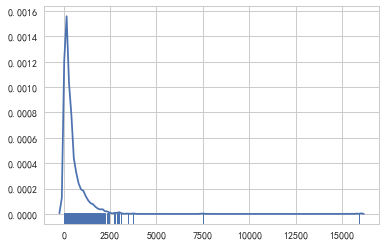

In [83]:
sns.distplot(total_dist[c.most_common(10)[0][0]], hist=False, rug=True)


In [107]:
freq_list=[2.3,3.4,4.323,5.4,6.12,3434.2,32,4,1]

In [108]:
np.argsort(freq_list)

array([8, 0, 1, 7, 2, 3, 4, 6, 5])

In [111]:
indices = np.argsort(freq_list)[:-15:-1]

In [112]:
[freq_list[i] for i in indices]

[3434.2, 32, 6.12, 5.4, 4.323, 4, 3.4, 2.3, 1]

In [118]:
def maxClickFreq(db,sqlstr):

    data_iterator = dataGen(db, sqlstr)

    # 如果两次动作的间隔时间大于３００秒，算两次连续动作
    interval_limit = 300
    ton_n = 10
    first_action_time = -1
    last_action_time = -1
    times = -1.
    current_player = -1
    freq_list = []
    alist = []
    one_interval_list = []

    total_index_dict = collections.defaultdict(list)

    starting_time = time.time()
    counter = 0

    for row in data_iterator:
        counter += 1
        if counter % 1000000 == 0:
            print("%s lines processed\n" % counter)
            # print(timestamp)

        player_id = row[0]
        timestamp = row[1]
        level = row[2]
        action = row[3]

        # 如果更换用户，初始化所有值
        if player_id != current_player:

            diff = last_action_time - first_action_time
            if diff != 0:
                freq = times / diff
                freq_list.append(freq)
                alist.append(one_interval_list)

            if current_player != -1:
                indices = np.argsort(freq_list)[:-(ton_n+1):-1]
#                 print(len(freq_list))
                max_freq_list = [freq_list[i] for i in indices]
                max_freq_action_list = [alist[i] for i in indices]
                total_index_dict[current_player] = [max_freq_list,max_freq_action_list]

            first_action_time = timestamp
            last_action_time = timestamp
            freq_list = []
            one_interval_list =[]
            alist = []
            times = -1.
            current_player = player_id
            # print("================")
        #         if player_id == 36028840385154595:

        #             print("last " + str(last_action_time))
        #             print("first " + str(first_action_time))
        #             print("now " + str(timestamp))
        # ignore actions that had been done after the vip registering.
        if level >= 1:
            continue

        if timestamp - last_action_time > interval_limit:

            diff = last_action_time - first_action_time
            if diff != 0:
                freq = times / diff
                freq_list.append(freq)
                alist.append(one_interval_list)
            one_interval_list= []
            first_action_time = timestamp
            times = -1.

        times += 1
        last_action_time = timestamp
        one_interval_list.append(action)

    diff = last_action_time - first_action_time
    if diff != 0:
        freq = times / diff
        freq_list.append(freq)
        alist.append(one_interval_list)

    indices = np.argsort(freq_list)[:-(ton_n + 1):-1]
    max_freq_list = [freq_list[i] for i in indices]
    max_freq_action_list = [alist[i] for i in indices]
    total_index_dict[current_player] = [max_freq_list, max_freq_action_list]

    pd_dist = pd.DataFrame(list(total_index_dict.items()), columns=['Player', 'FreqAction'])

    return pd_dist

In [119]:
sqlstr = "SELECT yonghu_id, timestamp, vip_level,action FROM maidian ORDER BY yonghu_id,timestamp ASC;"
freqAction = maxClickFreq(db4,sqlstr)

1000000 lines processed

2000000 lines processed

3000000 lines processed

4000000 lines processed

5000000 lines processed

6000000 lines processed

7000000 lines processed

8000000 lines processed



In [127]:
c = collections.Counter()

In [130]:
freqAction['FreqAction'].apply(lambda x:c.update(x[1][0]))

IndexError: list index out of range

In [195]:
freqAction

,Player,FreqAction
0,1039,"[[0.2506426735218509], [[UIRoot2D/NormalPanel/..."
1,1263,"[[0.47560975609756095, 0.41929133858267714, 0...."
2,2985,"[[0.18128654970760233], [[UIRoot2D/NormalPanel..."
3,4421,"[[0.24049914917753829], [[UIRoot2D/NormalPanel..."
4,6316,"[[0.40298507462686567, 0.3091247672253259, 0.3..."
5,6435,"[[0.30938833570412516], [[UIRoot2D/ModalPanel/..."
6,8165,"[[0.5, 0.275, 0.2556894243641232, 0.2300319488..."
7,8614,"[[0.3870752831445703, 0.1824175824175824, 0.16..."
8,8857,"[[0.5327102803738317, 0.2907009215302988, 0.24..."
9,10532,"[[0.28528377699648416, 0.15456238361266295], [..."


___

In [289]:
def targetActionTimes(db,sqlstr,target_action_lists):

    data_iterator = dataGen(db, sqlstr)
    
    current_player = -1

    total_index_dict = collections.defaultdict(list)
    action_contribution_dict = {}
    counter = 0

    for row in data_iterator:
        counter += 1
        if counter % 1000000 == 0:
            print("%s lines processed\n" % counter)
            # print(timestamp)

        player_id = row[0]
        timestamp = row[1]
        action = row[2]
        vip = row[3]
        # 如果更换用户，初始化所有值
        if player_id != current_player:

            temp_list = []
            for k, v in action_contribution_dict.items():
                temp_list.append([k, v])

            if current_player != -1:
                total_index_dict[current_player] = temp_list

            action_contribution_dict.clear()

            for k in target_action_lists:
                action_contribution_dict[k] = 0
            player_list = []
            current_player = player_id

        if vip >= 1:
            continue

        if action in target_action_lists:
            action_contribution_dict[action] += 1

    temp_list = []
    for k, v in action_contribution_dict.items():
        temp_list.append([k, v])
    total_index_dict[current_player] = temp_list

    temp = pd.DataFrame(list(total_index_dict.items()), columns=['Player', 'KeyFactor'])

    return temp

In [290]:

with open("/home/maoan/maidianAnalysis/level2-uianalysis/outlier-actions", 'r') as f:
    alist = [ele.strip() for ele in f.readlines()]

In [291]:
alist

['UIRoot2D/NormalPanel/BattleWin/Go_TeamSkill/Btn_TeamSkill',
 'UIRoot2D/NormalPanel/HeroListWin/Btn_Back',
 'UIRoot2D/ModalPanel/StageInfoWin/Go_StageInfo/Btn_Start',
 'UIRoot2D/NormalPanel/QuestWin/Go_Quest/Go_QuestList/Go_ScrollRect/Go_Content/Go_AchievementItem_01/Btn_Reward',
 'UIRoot2D/ModalPanel/PrivilegeWin/Go_Privilege/Go_Privilege/Go_RechargePrice/Go_ItemList/Go_Item2/Img_Frame',
 'UIRoot2D/NormalPanel/RobPlayerListWin/Go_RobTargetSelecte/Btn_Change',
 'UIRoot2D/NormalPanel/RobWin/Go_Rob/Go_TreasureList/Go_Layout/Go_TreasureListItem_Win_Rob(Clone)',
 'UIRoot2D/NewGuidePanel/Btn_Ensure',
 'UIRoot2D/NormalPanel/BossInvadeBattleWin/Go_HeroSkill/Btn_CommonAttack',
 'UIRoot2D/NormalPanel/DuelistBattleWin/Go_HeroSkill/Btn_CommonAttack',
 'UIRoot2D/NormalPanel/EquipStrengthenWin/Go_Strengthen/Btn_strengthen',
 'UIRoot2D/ModalPanel/StoryModeNewWin',
 'UIRoot2D/NormalPanel/HeroAttributeWin/Go_HeroAttribute/Go_ScrollList/Go_List/Go_AttributeTip/Go_ItemList/Go_Item_0',
 'UIRoot2D/Normal

In [292]:
sqlstr="SELECT yonghu_id, timestamp, action, vip_level FROM maidian ORDER BY yonghu_id,timestamp ASC;"
user_target = targetActionTimes(db4,sqlstr,alist)

1000000 lines processed

2000000 lines processed

3000000 lines processed

4000000 lines processed

5000000 lines processed

6000000 lines processed

7000000 lines processed

8000000 lines processed



In [295]:
user_target.iloc[1,1]

[['UIRoot2D/NormalPanel/BattleWin/Go_TeamSkill/Btn_TeamSkill', 38],
 ['UIRoot2D/NormalPanel/HeroListWin/Btn_Back', 42],
 ['UIRoot2D/ModalPanel/StageInfoWin/Go_StageInfo/Btn_Start', 29],
 ['UIRoot2D/NormalPanel/QuestWin/Go_Quest/Go_QuestList/Go_ScrollRect/Go_Content/Go_AchievementItem_01/Btn_Reward',
  28],
 ['UIRoot2D/ModalPanel/PrivilegeWin/Go_Privilege/Go_Privilege/Go_RechargePrice/Go_ItemList/Go_Item2/Img_Frame',
  0],
 ['UIRoot2D/NormalPanel/RobPlayerListWin/Go_RobTargetSelecte/Btn_Change', 0],
 ['UIRoot2D/NormalPanel/RobWin/Go_Rob/Go_TreasureList/Go_Layout/Go_TreasureListItem_Win_Rob(Clone)',
  0],
 ['UIRoot2D/NewGuidePanel/Btn_Ensure', 0],
 ['UIRoot2D/NormalPanel/BossInvadeBattleWin/Go_HeroSkill/Btn_CommonAttack',
  266],
 ['UIRoot2D/NormalPanel/DuelistBattleWin/Go_HeroSkill/Btn_CommonAttack', 130],
 ['UIRoot2D/NormalPanel/EquipStrengthenWin/Go_Strengthen/Btn_strengthen', 1],
 ['UIRoot2D/ModalPanel/StoryModeNewWin', 54],
 ['UIRoot2D/NormalPanel/HeroAttributeWin/Go_HeroAttribute/G

### 付费玩家与非付费玩家

接近82％的用户是非vip用户，等级大于等于１．

In [137]:
(keyIndexData.groupby('yonghu_id').apply(lambda x : (x['vip_level'].tail(1) == 0).values)).value_counts()

[True]     3752
[False]     799
dtype: int64

In [296]:
3752+799

4551

In [7]:
3752/(3752+799)

0.8244341902878488

In [139]:
nonliush = keyIndexData.groupby("yonghu_id").apply(lambda x:x['num_days_played'].tail(1).values>1).apply(lambda x:x[0])
nonliush = nonliush.reset_index(name="stay")
nonliush.rename(columns={'yonghu_id': 'Player'}, inplace=True)
# res = pd.merge(cf, nonliush, how='inner', on=['Player'])
# res.loc[res['stay'],].groupby("vip").count()

In [140]:
nonliush

,Player,stay
0,1039,False
1,1263,True
2,2985,False
3,4421,False
4,6316,True
5,6435,False
6,8165,True
7,8614,True
8,8857,True
9,10532,False


In [96]:
res.corr()

,Player,Freq,vip,stay
Player,1.000000,0.002907,-0.030036,-0.048569
Freq,0.002907,1.000000,0.250351,0.246217
vip,-0.030036,0.250351,1.000000,0.507188
stay,-0.048569,0.246217,0.507188,1.000000


从上面分析可以看出，在次留玩家中，付费用户比例明显偏高

In [97]:
res

,Player,Freq,vip,stay
0,1039,0.250643,False,False
1,1263,0.294770,True,True
2,2985,0.181287,False,False
3,4421,0.240499,False,False
4,6316,0.277462,False,True
5,6435,0.309388,False,False
6,8165,0.224425,False,True
7,8614,0.142897,False,True
8,8857,0.268525,False,True
9,10532,0.219923,False,False


In [302]:
vip.loc[nonliush['stay'],'vip'].value_counts()
# vip_stay_users = res.loc[nonliush['stay'],].loc[vip['vip'],'KeyFactor']

False    932
True     710
Name: vip, dtype: int64

In [303]:
932+710

1642

#### 抽出用户付费前的行为与非付费用户的行为对比，找出差异。

1. 点击频率

In [71]:
def clickFrequencyBeforeVip(db,sqlstr):

    data_iterator = dataGen(db, sqlstr)

    #如果两次动作的间隔时间大于３００秒，算两次连续动作
    interval_limit = 300
    first_action_time = -1
    last_action_time = -1
    times = -1.
    current_player = -1
    freq_list = []
    total_index_dict = collections.defaultdict(list)

    starting_time = time.time()
    counter = 0

    for row in data_iterator:
        counter += 1
        if counter % 1000000 == 0:
            print("%s lines processed\n" % counter)
            # print(timestamp)

        player_id = row[0]
        timestamp = row[1]
        level = row[2]
        

#         ## 如果在启动阶段，用户的关键指标可能是０，因为需要从服务器取得数据。所以忽略。
#         if major_action == None or major_action == "启动":
#             continue

        # 如果更换用户，初始化所有值
        if player_id != current_player:


            diff = last_action_time - first_action_time
            if diff != 0:
                freq = times / diff
                freq_list.append(freq)

            if current_player != -1:
                total_index_dict[current_player] = np.median(freq_list)

            first_action_time = timestamp
            last_action_time = timestamp
            freq_list = []
            times = -1.
            current_player = player_id
            # print("================")
#         if player_id == 36028840385154595:

#             print("last " + str(last_action_time))
#             print("first " + str(first_action_time))
#             print("now " + str(timestamp))
        if level >=1:
            continue
    
        if timestamp - last_action_time > interval_limit:

            diff = last_action_time - first_action_time
            if diff != 0:
                freq = times / diff
                freq_list.append(freq)

            first_action_time = timestamp
            times = -1.

        times += 1
        last_action_time = timestamp

    diff = last_action_time - first_action_time
    if diff != 0:
        freq = times / diff
        freq_list.append(freq)


    total_index_dict[current_player] = np.median(freq_list)
        
    pd_dist = pd.DataFrame(list(total_index_dict.items()), columns=['Player', 'Freq'])

    return pd_dist


In [72]:
sqlstr = "SELECT yonghu_id, timestamp, vip_level FROM maidian ORDER BY yonghu_id,timestamp ASC;"
cf = clickFrequencyBeforeVip(db=db4,sqlstr=sqlstr)

/home/maoan/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/maoan/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1000000 lines processed

2000000 lines processed

3000000 lines processed

4000000 lines processed

5000000 lines processed

6000000 lines processed

7000000 lines processed

8000000 lines processed



In [102]:
vip = keyIndexData.groupby('yonghu_id').apply(lambda x : (x['vip_level'].tail(1) != 0).values)

In [103]:
vip = vip.reset_index(name="vip")

In [109]:
(vip['yonghu_id'] == cf['Player']).sum()

4551

In [73]:
cf.loc[:,'vip'] = vip['vip']

In [74]:
cf.loc[:,'vip'] = cf.loc[:,'vip'].apply(lambda x: x[0])

vip
False    Axes(0.125,0.125;0.775x0.755)
True     Axes(0.125,0.125;0.775x0.755)
Name: Freq, dtype: object

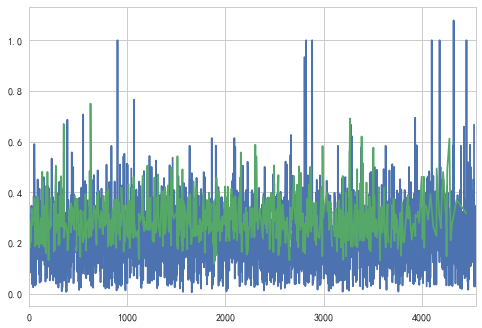

In [14]:
cf.groupby("vip")['Freq'].plot()

In [15]:
cf.groupby("vip")['Freq'].describe()

vip         
False  count    3651.000000
       mean        0.222846
       std         0.111320
       min         0.005618
       25%         0.149782
       50%         0.216251
       75%         0.287416
       max         1.078307
True   count     793.000000
       mean        0.295042
       std         0.083740
       min         0.118865
       25%         0.238994
       50%         0.286036
       75%         0.340176
       max         0.750000
Name: Freq, dtype: float64

/home/maoan/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


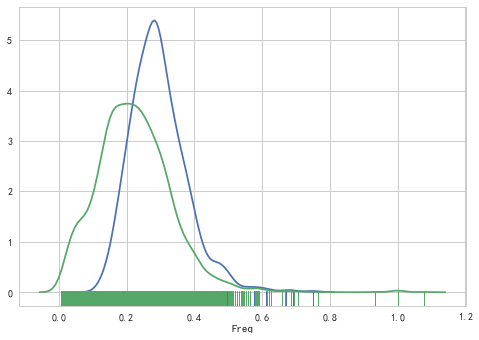

In [141]:
sns.distplot(cf.loc[cf['vip'] >=1,'Freq'], hist=False, rug=True)
sns.distplot(cf.loc[cf['vip'] <1,'Freq'], hist=False, rug=True)


In [101]:
cf

,Player,Freq,vip
0,1039,0.250643,False
1,1263,0.294770,True
2,2985,0.181287,False
3,4421,0.240499,False
4,6316,0.277462,False
5,6435,0.309388,False
6,8165,0.224425,False
7,8614,0.142897,False
8,8857,0.268525,False
9,10532,0.219923,False


____

#### 玩家玩的时间段 - (上午，中午，下午，晚上)

In [98]:
morning_b = 8
morning_e = 12
noon_b = 12
noon_e=14
afternoon_b = 14
afternoon_e = 18
night_b = 20


In [99]:
def whichInterval(time):
    
    hour = datetime.fromtimestamp(time).hour

    if hour >= morning_b and hour <= morning_e:
        return "morning"
    elif hour > noon_b and hour <= noon_e:
        return "noon"
    elif hour > afternoon_b and hour <= afternoon_e:
        return "afternoon"
    else:
        return "night"

def playInterval(db,sqlstr):

    data_iterator = dataGen(db, sqlstr)

    #如果两次动作的间隔时间大于3600秒，算两次连续动作
    interval_limit = 3600
    first_action_time = -1
    last_action_time = -1
    
    current_player = -1
    interval_list = []
    total_index_dict = collections.defaultdict(list)

    starting_time = time.time()
    counter = 0

    for row in data_iterator:
        counter += 1
        if counter % 1000000 == 0:
            print("%s lines processed\n" % counter)
            # print(timestamp)

        player_id = row[0]
        timestamp = row[1]
        level = row[2]
        

#         ## 如果在启动阶段，用户的关键指标可能是０，因为需要从服务器取得数据。所以忽略。
#         if major_action == None or major_action == "启动":
#             continue

        # 如果更换用户，初始化所有值
        if player_id != current_player:
            
            interval_list.append(whichInterval(first_action_time))
            most_freq_val = collections.Counter(interval_list).most_common(1)[0][0]  
            if current_player != -1:
                total_index_dict[current_player] = most_freq_val

            first_action_time = timestamp
            last_action_time = timestamp
            interval_list = []
            current_player = player_id
            # print("================")

        if level >=1:
            continue
    
        if timestamp - last_action_time > interval_limit:
            
            interval_list.append(whichInterval(first_action_time))
            first_action_time = timestamp
            
        last_action_time = timestamp
                                     
    interval_list.append(whichInterval(first_action_time))
    most_freq_val = collections.Counter(interval_list).most_common(1)[0][0] 
    total_index_dict[current_player] = most_freq_val
        
    pd_dist = pd.DataFrame(list(total_index_dict.items()), columns=['Player', 'Freq'])

    return pd_dist

In [100]:
sqlstr = "SELECT yonghu_id, timestamp, vip_level FROM maidian ORDER BY yonghu_id,timestamp ASC;"
interval_l = playInterval(db=db4,sqlstr=sqlstr)

1000000 lines processed

2000000 lines processed

3000000 lines processed

4000000 lines processed

5000000 lines processed

6000000 lines processed

7000000 lines processed

8000000 lines processed



In [19]:
cf.loc[:,'interval'] = interval_l['Freq']

In [20]:
sum([True,False])

1

In [21]:
cf.groupby("interval")['vip'].apply(lambda x:sum(x)/len(x))

interval
afternoon    0.140329
morning      0.158209
night        0.187519
noon         0.151961
Name: vip, dtype: float64

TypeError: unsupported operand type(s) for /: 'str' and 'int'

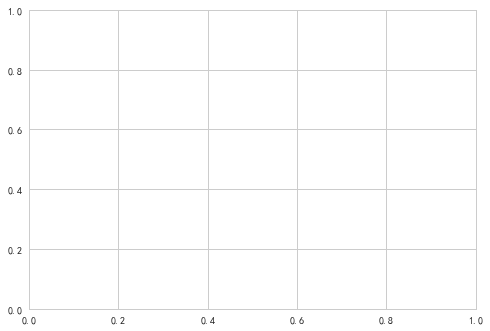

In [139]:
sns.distplot(cf.loc[cf['vip'] >=1,'interval'], hist=False, rug=True)


#### 使用的操作系统

In [113]:
devices = keyIndexData.groupby("yonghu_id").apply(lambda x : x['shebei'].value_counts().index[0])

In [114]:
devices = devices.reset_index(name="device")
cf.loc[:,'device'] = devices['device']

In [115]:
cf

,Player,Freq,vip,interval,device,BattleRatio
0,1039,0.250643,False,afternoon,SM-T710,0.172126
1,1263,0.294770,True,afternoon,ASUS_Z00AD,0.051894
2,2985,0.181287,False,noon,iPhone (Andrey),0.000000
3,4421,0.240499,False,night,M3s,0.209184
4,6316,0.277462,False,night,Redmi 4,0.083237
5,6435,0.309388,False,night,iPad Катя,0.000000
6,8165,0.224425,False,night,Lenovo A3500-H,0.059650
7,8614,0.142897,False,night,Le X625,0.000000
8,8857,0.268525,False,night,SGP512,0.028791
9,10532,0.219923,False,night,Boost3,0.028470


In [116]:
device_vip = cf.groupby("device")['vip'].apply(lambda x : (sum(x)/len(x),len(x)))

In [117]:
def deviceToRatio(x):
    if x[1]>=10:
        return x[0]
    else:
        return 0

In [118]:
vip_device_ratio = device_vip.apply(lambda x:deviceToRatio(x))

In [123]:
cf = cf.replace(vip_device_ratio)

In [125]:
cf.to_csv("userFile_vip.csv",index=False)

In [127]:
pd.get_dummies(cf).to_csv("userFile_vip.csv",index=False)

In [129]:
cf.dropna(axis=0, how='any', inplace=True)

In [134]:
cf['vip'].value_counts()

False    3651
True      793
Name: vip, dtype: int64

#### 玩法分析
____

1. 核心玩法停留时间－中位数
2. 核心玩法停留时间的所占的比例


In [27]:
def wanfa_analysis(in_action, out_action, data_iterator, loss_window=20):
    time_of_total_stay = 0

    stay_limit = 1500
    time_limit = 600
    num_enter = 0
    num_of_correct_exit = 0

    current_player = -1

    find_flag = False
    correct_exit = True
    window_len = 0
    time_list = []

    starting_time = time.time()
    counter = 0

    enter_time = 0
    total_exit_time = 0
    stay_time = 0

    first_action_time = -1
    last_action_time = -1

    duringDict = {}

    for row in data_iterator:

        counter += 1
        if counter % 1000000 == 0:
            print("%s lines processed\n" % counter)
            # print("total enter:" + str(num_enter))
            # print("correct exit :" + str(num_of_correct_exit))

        player_id = row[0]
        action = row[2]
        timestamp = row[1]
        level =row[3]

        # 如果更换用户，初始化所有值，并且计算上一个用户的所有以及正确的停留的时间。
        if player_id != current_player:

            find_flag = False
            window_len = 0

            if current_player != -1:
                time_of_total_stay += last_action_time - first_action_time

                duringDict[current_player] = [time_list, time_of_total_stay]

            current_player = player_id

            first_action_time = timestamp
            last_action_time = timestamp

            enter_time = 0
            total_exit_time = 0
            stay_time = 0
            time_of_total_stay = 0
            time_list = []
        
        if level >=1:
            continue
        
        ##　如果这次点击的时间跟上一次点击的时间的差小于阈值，则进入计算累计时间。否则重新定义
        # 连续点击的第一次。
        if timestamp - last_action_time > time_limit:
            time_of_total_stay += (last_action_time - first_action_time)
#             if player_id == 37902:
#                 print("total: {0}, current: {1},last_action: {2}, first_action{3}".
#                       format(time_of_total_stay,timestamp,last_action_time,first_action_time))
            first_action_time = timestamp
            

        # 如果对某一个用户，第一次找到相应的进入UI动作，记录总人数加一并标记。记录进入时间
        if (compareAction(action, in_action) and (not find_flag)):
            find_flag = True
            enter_time = timestamp
            total_exit_time = timestamp
            num_enter += 1
            last_action_time = timestamp
            window_len = 0
            continue

        # 如果已找到进入动作，判断此时动作是否为退出动作。如果是，正确退出加一，否则判断窗口长度是否大于
        # 标准值，如果是的话，此用户记录为非正常退出，并记录时间
        if find_flag:
            if compareAction(action, out_action):
                num_of_correct_exit += 1
                stay_time = (timestamp - enter_time)
#                 if player_id == 37902:
#                     print("correct: {0}, current: {1},enter_time: {2}".
#                       format(stay_time,timestamp,enter_time))
                if timestamp - last_action_time <= time_limit:
                    time_list.append(stay_time)
                
                find_flag = False
            else:
                window_len += 1
                if window_len >= loss_window or (timestamp - last_action_time) > time_limit:

                    stay_time = (last_action_time - enter_time)
#                     if player_id == 37902:
#                         print("non-correct: {0}, current: {1},enter_time: {2}".
#                       format(stay_time,timestamp,enter_time))
                    time_list.append(stay_time)
                    find_flag = False
        
        
        last_action_time = timestamp


    time_of_total_stay += last_action_time - first_action_time

    duringDict[current_player] = [time_list, time_of_total_stay]

    pd_dist = pd.DataFrame(list(duringDict.items()), columns=['Player', 'TimeOnUI'])

    return pd_dist


In [28]:
enter_action = "UIRoot2D/ModalPanel/TeamEditWin/Btn_Start"
exit_action = "UIRoot2D/NormalPanel/BattleSettlementWin/Img_Bg/Go_Btn/Btn_Quit"

sqlstr = "SELECT yonghu_id,timestamp,action duiwu_level FROM maidian ORDER BY yonghu_id,timestamp ASC;"
data_iterator = dataGen(db4,sqlstr)
u_play = wanfa_analysis(in_action=enter_action,out_action=exit_action,data_iterator=data_iterator)

correct: 441, current: 1496650937,enter_time: 1496650496
non-correct: 120, current: 1496651173,enter_time: 1496651053
non-correct: 240, current: 1496652095,enter_time: 1496651853
non-correct: 84, current: 1496652200,enter_time: 1496652114
non-correct: 238, current: 1496652984,enter_time: 1496652744
non-correct: 159, current: 1496653666,enter_time: 1496653507
non-correct: 151, current: 1496653934,enter_time: 1496653782
total: 4680, current: 1496663635,last_action: 1496655038, first_action1496650358
total: 4813, current: 1496668759,last_action: 1496663768, first_action1496663635
correct: 4991, current: 1496668759,enter_time: 1496663768
non-correct: 111, current: 1496668942,enter_time: 1496668827
total: 5265, current: 1496670069,last_action: 1496669211, first_action1496668759
correct: 869, current: 1496670069,enter_time: 1496669200
total: 5296, current: 1496672599,last_action: 1496670100, first_action1496670069
non-correct: 59, current: 1496672703,enter_time: 1496672643
total: 5422, curre

In [29]:
u_play

,Player,TimeOnUI
0,1039,"[[178, 36, 54], 1556]"
1,1263,"[[132, 128, 147, 167, 38, 45, 137, 37, 147], 1..."
2,2985,"[[], 171]"
3,4421,"[[114, 125, 130], 1763]"
4,6316,"[[133, 151, 147], 5177]"
5,6435,"[[], 1406]"
6,8165,"[[158, 131, 161], 7543]"
7,8614,"[[], 8317]"
8,8857,"[[118, 40, 37], 6772]"
9,10532,"[[72], 2528]"


In [55]:
cf

,Player,Freq,vip,interval,device,BattleRatio
0,1039,0.250643,False,afternoon,SM-T710,0.172126
1,1263,0.294770,True,afternoon,ASUS_Z00AD,0.051894
2,2985,0.181287,False,noon,iPhone (Andrey),0.000000
3,4421,0.240499,False,night,M3s,0.209184
4,6316,0.277462,False,night,Redmi 4,0.083237
5,6435,0.309388,False,night,iPad Катя,0.000000
6,8165,0.224425,False,night,Lenovo A3500-H,0.059650
7,8614,0.142897,False,night,Le X625,0.000000
8,8857,0.268525,False,night,SGP512,0.028791
9,10532,0.219923,False,night,Boost3,0.028470


In [31]:
cf.loc[:,'BattleRatio'] = u_play['TimeOnUI'].apply(lambda x:sum(x[0])/(x[1]+1))

In [30]:
u_play.loc[u_play['Player'] == 37902,'TimeOnUI'].values

array([[[441, 120, 240, 84, 238, 159, 151, 111, 59], 5431]], dtype=object)

In [35]:
cf.loc[cf['BattleRatio']==0,]

,Player,Freq,vip,interval,device,BattleRatio
2,2985,0.181287,False,noon,iPhone (Andrey),0.0
5,6435,0.309388,False,night,iPad Катя,0.0
7,8614,0.142897,False,night,Le X625,0.0
11,11030,0.083333,False,noon,GT-I9500,0.0
18,15532,0.159832,False,night,m2,0.0
20,17234,0.190476,False,night,A211,0.0
21,17251,0.151515,False,afternoon,MI 3W,0.0
22,17842,0.231270,False,night,SM-N910C,0.0
27,23606,0.115422,False,morning,SM-T561,0.0
28,24121,0.037825,False,night,Tesla,0.0


In [135]:
cf.groupby("vip")['BattleRatio'].describe()

vip         
False  count    3651.000000
       mean        0.148199
       std         0.176868
       min         0.000000
       25%         0.000000
       50%         0.095051
       75%         0.236720
       max         0.965847
True   count     793.000000
       mean        0.057804
       std         0.039771
       min         0.000000
       25%         0.032018
       50%         0.049516
       75%         0.072755
       max         0.365212
Name: BattleRatio, dtype: float64

plot the distribution to show the ability of the **BattleRatio** feature to distinguish the vip or non-vip users.

/home/maoan/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


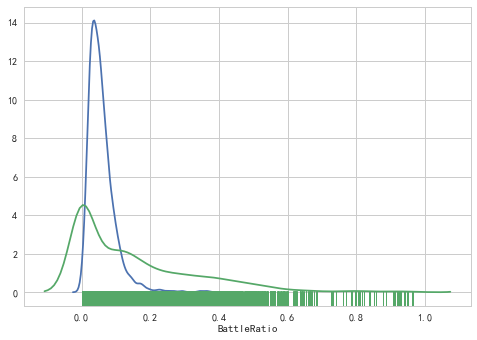

In [138]:
sns.distplot(cf.loc[cf['vip'] >=1,'BattleRatio'], hist=False, rug=True)
sns.distplot(cf.loc[cf['vip'] <1,'BattleRatio'], hist=False, rug=True)


___

In [48]:
keyIndexData.loc[keyIndexData['yonghu_id'] == 24407,'vip_level'].unique()

array([0, 2, 3])

In [52]:
(keyIndexData['vip_level'] != 0).sum()

3806442

In [11]:
features = ['shebei','qudao','duiwu_level', 'duiwu_experience',
       'duiwu_zhanli', 'vip_level', 'vip_experience', 'ugc_credits',
       'ugc_castle_level', 'ugc_castle_experience', 'jinbi', 'zuanshi',
       'shuijing', 'tili', 'jingli', 'shiyou', 'mojingshi', 'hero_peiyang_shi',
       'hero_tupo_shi', 'exp_book_1_amount', 'exp_book_2_amount',
       'exp_book_3_amount', 'exp_book_4_amount','num_days_played']

num_features = ['duiwu_level', 'duiwu_experience',
       'duiwu_zhanli', 'vip_level', 'vip_experience', 'ugc_credits',
       'ugc_castle_level', 'ugc_castle_experience', 'jinbi', 'zuanshi',
       'shuijing', 'tili', 'jingli', 'shiyou', 'mojingshi', 'hero_peiyang_shi',
       'hero_tupo_shi', 'exp_book_1_amount', 'exp_book_2_amount',
       'exp_book_3_amount', 'exp_book_4_amount']


In [15]:
read_f = ','.join(num_features)

In [16]:
read_f

'duiwu_level,duiwu_experience,duiwu_zhanli,vip_level,vip_experience,ugc_credits,ugc_castle_level,ugc_castle_experience,jinbi,zuanshi,shuijing,tili,jingli,shiyou,mojingshi,hero_peiyang_shi,hero_tupo_shi,exp_book_1_amount,exp_book_2_amount,exp_book_3_amount,exp_book_4_amount'

In [21]:
a = [1232] * 3
b = [232,4,5,6,7]

In [22]:
np.concatenate((b, a))

array([ 232,    4,    5,    6,    7, 1232, 1232, 1232])

In [23]:
def padAndSample(x,n,feature):
    v = x[feature].values
    
    if len(v) < n:
        padding = [v[-1]] * (n-len(v))
        return np.concatenate((v, padding))
    else:
        return v
         

In [26]:
padding_df = keyIndexData.groupby('yonghu_id').apply(lambda x:padAndSample(x,100,"jinbi"))
# np.random.choice(keyIndexData['jinbi'].values, 3, replace=False)
o_u = pd.Series(padding_df[1039])

In [151]:
def poly_fit(l,poly_deg):
    y = l.values
    x = l.index.tolist()
    z = np.polyfit(x=x, y=y, deg=poly_deg)
    p = np.poly1d(z)
    return p.c

In [79]:
last_ele = keyIndexData.groupby('yonghu_id').tail(1)
first_ele =  keyIndexData.groupby('yonghu_id').head(1)
first_ele.reset_index(drop=True,inplace=True)
last_ele.reset_index(drop=True,inplace=True)


In [155]:
user_trend = keyIndexData.groupby("yonghu_id").apply(lambda x: poly_fit(x["jinbi"],4))


In [193]:
user_para = pd.DataFrame()

In [194]:
for i in range(4+1):
    name = "poly_"+str(4-i)
    user_para.loc[:,name] = user_trend.apply(lambda x: x[i])
    user_para.loc[:,name] = preprocessing.StandardScaler().fit_transform(user_para[name].values.reshape(-1,1))

In [86]:
for f in last_ele.iloc[:,2:].columns:
    name = f + "_diff"
    diff_df.loc[:,name] = last_ele[f] - first_ele[f]

In [196]:
jinbi = keyIndexData.loc[keyIndexData['yonghu_id'] == 6316,'jinbi']
y = jinbi.values
x = jinbi.index.tolist()
z=np.polyfit(x=x,y=y,deg=4)

In [197]:
z

array([  1.80631508e-06,  -4.75881314e-02,   4.67397034e+02,
        -2.02602234e+06,   3.26689557e+09])

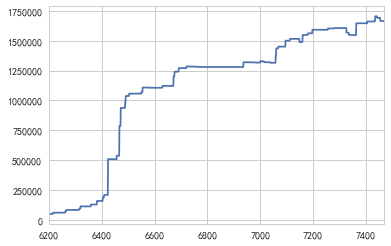

In [198]:
jinbi.plot()

In [199]:
p = np.poly1d(z)

In [200]:
p.c

array([  1.80631508e-06,  -4.75881314e-02,   4.67397034e+02,
        -2.02602234e+06,   3.26689557e+09])

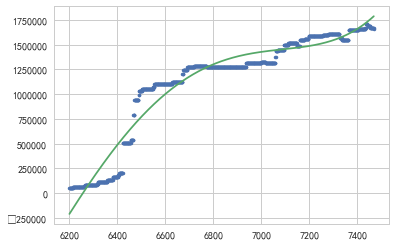

In [201]:
xp = np.linspace(0, 400, 1)
_ = plt.plot(x,y,'.',x, p(x), '-')

plt.show()

In [84]:
last_ele['duiwu_experience'] - first_ele['duiwu_experience']

0        -30
1        286
2         20
3         20
4         42
5         24
6         32
7         52
8         72
9         24
10       488
11        20
12      2126
13        52
14       932
15      1200
16        26
17        12
18        28
19        16
20         0
21        20
22        28
23        22
24        20
25        82
26        28
27        28
28         0
29      1392
        ... 
4521      20
4522       0
4523      28
4524      24
4525      20
4526      20
4527       0
4528      26
4529      26
4530      20
4531      22
4532      22
4533      20
4534       0
4535       0
4536      24
4537       0
4538      26
4539      20
4540      28
4541      20
4542      20
4543      28
4544      20
4545      28
4546      20
4547      20
4548      20
4549      20
4550       0
Name: duiwu_experience, dtype: int64

In [54]:
last_ele.iloc[:,2:].columns

Index(['duiwu_level', 'duiwu_experience', 'duiwu_zhanli', 'vip_level',
       'vip_experience', 'ugc_credits', 'ugc_castle_level',
       'ugc_castle_experience', 'jinbi', 'zuanshi', 'shuijing', 'tili',
       'jingli', 'shiyou', 'mojingshi', 'hero_peiyang_shi', 'hero_tupo_shi',
       'exp_book_1_amount', 'exp_book_2_amount', 'exp_book_3_amount',
       'exp_book_4_amount'],
      dtype='object')

In [5]:
def hoursGrowth(x):
    first_row = x['happen_time'].head(1)
    pre = x['happen_time'].shift(1)
    return (x['happen_time'] - pre).apply(lambda x: x>60*5)

In [18]:
def merge_dicts(*dict_args):
    """
    Given any number of dicts, shallow copy and merge into a new dict,
    same valued added to a same key
    """
    result = collections.defaultdict(list)
    for dictionary in dict_args:
        for k in dictionary.keys():
            result[k].append(dictionary.get(k))
    return result

### 关键指标小时增长

In [97]:
def keyIndexGrowthByHours(index, interval_in_secs, db, player = None, days=3):
    num_enter = 0

    dbms = DatabaseManager(db)
    sqlstr = "SELECT player_id, " + index + ", happen_time, major_class FROM maidian ORDER BY player_id,happen_time ASC;"
    data_iterator = dataGen(dbms, sqlstr)

    current_player = -1
    first_action_time = -1
    last_action_time = -1
    last_key_value = -1
    one_block_time = 0
    time_limit = 300

    total_index_dict = collections.defaultdict(list)
    player_list = []
    starting_time = time.time()
    counter = 0
    # dist = collections.defaultdict(int)

    for row in data_iterator:

        counter += 1
        if counter % 100000 == 0:
            print("%s lines processed\n" % counter)
            # print(timestamp)

        key_factor = row[1]
        player_id = row[0]
        timestamp = row[2]
        major_action = row[3]

        if player_id ==252201622525511796:
            continue

        # 如果更换用户，初始化所有值
        if player_id != current_player:
            first_action_time = timestamp
            last_action_time = timestamp
            one_block_time = 0
            ##忽略最后不满一小时的数据
            # player_list.append(last_key_value)
            if len(player_list) == 0:
                player_list.append(last_key_value)

            if current_player != -1:
                total_index_dict[current_player] = player_list

            player_list = []
            current_player = player_id

        ## 如果在启动阶段，用户的关键指标可能是０，因为需要从服务器取得数据。所以忽略。
        if major_action == None or major_action == "启动":
            continue

        ##　如果这次点击的时间跟上一次点击的时间的差小于阈值，则进入计算累计时间。否则重新定义
        # 连续点击的第一次。
        if timestamp - last_action_time <= time_limit:
            during_time = last_action_time - first_action_time
            ## 如果这一次的时间差加上前面的累计时间大于阈值，则记录上一次
            # 的值为上一个时间段的关键指标的值
            if during_time + one_block_time >= interval_in_secs:
                player_list.append(last_key_value)

                first_action_time = timestamp
                one_block_time = 0

            ## 记录上一次的累计时间
        else:
            one_block_time += last_action_time - first_action_time
            first_action_time = timestamp


        last_action_time = timestamp
        last_key_value = key_factor

    if len(player_list) == 0:
        player_list.append(last_key_value)

    total_index_dict[current_player] = player_list

    pd_dist = pd.DataFrame(list(total_index_dict.items()), columns=['Player', 'KeyFactor'])
#     pd_dist['KeyFactor'].apply(lambda x : len(x) != 0)
    return pd_dist
#     pd_dist.to_csv("所有用户关键指标小时增长情况.csv", encoding="utf_8",index=False)

    if player:
        single_user = pd_dist.loc[pd_dist['Player'] == player,]
        hour_index = pd.Series(single_user['KeyFactor'].values[0])
        name = str(player) + "_关键指标小时增长.csv"

        hour_index.to_csv(name, encoding="utf_8")
        return 0


    key_factor_list = pd_dist['KeyFactor'].values
    max_continue_hour = np.max([len(i) for i in key_factor_list])

    max_list = []
    min_list = []
    mean_list =[]
    median_list = []
    num_list = []
    for i in range(max_continue_hour):
        hour_list = [l[i] for l in key_factor_list if len(l) > i]
        print("For Hour {0}, there are {1} users ".format(i, len(hour_list)))
        print("Minimum {0} is {1}".format(index, np.min(hour_list)))
        min_list.append(np.min(hour_list))
        print("Maximun {0} is {1}".format(index, np.max(hour_list)))
        max_list.append(np.max(hour_list))
        print("Mean {0} is {1:0.2f}".format(index, np.mean(hour_list)))
        mean_list.append(np.mean(hour_list))
        print("Median {0} is {1}".format(index, np.median(hour_list)))
        median_list.append(np.median(hour_list))
        print("================================\n")
        num_list.append(i)

    max_index_value = pd.Series(max_list)
    min_index_value = pd.Series(min_list)
    mean_index_value = pd.Series(mean_list)
    median_index_value = pd.Series(median_list)
    num_hour = pd.Series(num_list)
    plot_df = pd.DataFrame({"小时":num_hour, "最大指标值":max_index_value,
                            "最小指标值": min_index_value,
                            "指标均值":mean_index_value,
                            "指标中位数": median_index_value})
    name = feature + "_小时增长_csv"
    plot_df.to_csv(name, encoding="utf_8", index=False)

#     sns.factorplot(x="who", y="survived", col="class", data=)
#     pd_dist.to_csv("关键指标小时增长情况２.csv", encoding="utf_8",index=False)


In [98]:
index="total_power"
interval_in_secs=3600
num_enter = 0
player = 36028840373811787

hourDF = keyIndexGrowthByHours(index, interval_in_secs, db)

100000 lines processed

200000 lines processed

300000 lines processed

400000 lines processed

500000 lines processed

600000 lines processed

700000 lines processed

800000 lines processed

900000 lines processed

1000000 lines processed

1100000 lines processed

1200000 lines processed

1300000 lines processed

1400000 lines processed

1500000 lines processed

1600000 lines processed

1700000 lines processed

1800000 lines processed

1900000 lines processed

2000000 lines processed

2100000 lines processed

2200000 lines processed

2300000 lines processed

2400000 lines processed

2500000 lines processed

2600000 lines processed

2700000 lines processed

2800000 lines processed

2900000 lines processed

3000000 lines processed

3100000 lines processed

3200000 lines processed

3300000 lines processed

3400000 lines processed

3500000 lines processed

3600000 lines processed

3700000 lines processed

3800000 lines processed

3900000 lines processed

4000000 lines processed

4100000 l

In [108]:
hourDF['1hour'] = hourDF['KeyFactor'].apply(lambda x:x[0])

In [111]:
res = pd.merge(profile, hourDF, how='left', on=['Player'])

,Player,Duration,Loss,Money,Freq,FirstTime,TimeOnUI,KeyFactor,1hour
0,36028840373795443,10528,True,False,0.165793,8066,3,"[4020, 4248]",4020.0
1,36028840373806493,1409,False,False,0.398864,0,6,[3178],3178.0
2,36028840373807939,4336,True,False,0.222622,293,5,[3725],3725.0
3,36028840373808717,26341,True,True,0.165294,475,4,"[7776, 8437, 7680, 9688, 11242, 11461, 11508, ...",7776.0
4,36028840373810279,3617,True,False,0.264029,1258,5,[4339],4339.0
5,36028840373811787,18328,True,True,0.119057,539,4,"[4598, 5218, 6165, 6763, 6885, 8216, 7403, 125...",4598.0
6,36028840373812793,21592,True,True,0.120133,292,3,"[4109, 3604, 5773, 7209, 7879, 8525, 9135, 117...",4109.0
7,36028840373815496,35327,True,True,0.118325,385,3,"[3955, 5470, 5326, 5543, 5030, 5244, 5622, 650...",3955.0
8,36028840373820832,23493,False,True,0.109736,1006,4,"[3287, 3772, 5160, 4992, 5180, 6120]",3287.0
9,36028840373821676,26054,True,True,0.149510,353,4,"[5016, 5941, 6567, 7835, 7868, 8153, 8830, 103...",5016.0


### 关键指标按动作变化情况

In [16]:
def keyIndexGrowthByActions(index, user_id, timestamp, action, interval_in_secs, db, growth = True, player=None):

    dbms = DatabaseManager(db)

    # sqlstr = "SELECT yonghu_id, " + index + ", timestamp, action FROM maidian ORDER BY yonghu_id,timestamp ASC;"
    sqlstr = "SELECT " + user_id + ", " + index + ", "+timestamp + ", " + action +" FROM maidian ORDER BY " +user_id+","+timestamp+ " ASC;"
    print(sqlstr)
    data_iterator = dataGen(dbms, sqlstr)

    if growth:
        changeF = 1
    else:
        changeF = -1

    current_player = -1
    first_action_time = -1
    last_action_time = -1
    last_key_value = -1
    one_block_time = 0
    num_growth = 0
    one_interval_clicks_list = 0
    time_limit = 300

    total_index_dict = collections.defaultdict(list)
    action_contribution_dict = collections.defaultdict(list)
    player_list = []
    starting_time = time.time()
    counter = 0
    # dist = collections.defaultdict(int)

    for row in data_iterator:
        counter += 1
        if counter % 100000 == 0:
            print("%s lines processed\n" % counter)
            # print(timestamp)

        key_factor = row[1]
        player_id = row[0]
        timestamp = row[2]
        action = row[3]
        # 如果更换用户，初始化所有值
        if player_id != current_player:

            temp_list = []
            for k, v in action_contribution_dict.items():
                temp_list.append([k, v])

            player_list.append(temp_list)

            first_action_time = timestamp
            last_action_time = timestamp
            one_block_time = 0
            ##忽略最后不满一小时的数据
            # player_list.append(last_key_value)

            if current_player != -1:
                total_index_dict[current_player] = player_list

            action_contribution_dict.clear()
            player_list = []
            last_key_value = key_factor
            last_action = action
            current_player = player_id

        # if major_action == None or major_action == "启动":
        #     continue

        if timestamp - last_action_time <= time_limit:
            during_time = last_action_time - first_action_time
            if during_time + one_block_time >= interval_in_secs:
                temp_list = []
                for k, v in action_contribution_dict.items():
                    temp_list.append([k, v])

                player_list.append(temp_list)
                first_action_time = timestamp
                one_block_time = 0
                action_contribution_dict.clear()
        else:
            one_block_time += last_action_time - first_action_time
            first_action_time = timestamp

            ## 如果关键指标增长了，记录增长量以及增长次数。
        if (key_factor-last_key_value) * changeF > 0:
            diff = (key_factor - last_key_value)*changeF
            # num_growth += 1
            temp_tuple = action_contribution_dict.get(last_action, [0, 0])
            temp_tuple[0] += diff
            temp_tuple[1] += 1
            action_contribution_dict[last_action] = temp_tuple

        last_action_time = timestamp
        last_key_value = key_factor
        last_action = action

    temp = pd.DataFrame(list(total_index_dict.items()), columns=['Player', 'KeyFactor'])

    # if player:
    #     single_user = temp.loc[temp['Player'] == player,]
    #     for i in range(3):
    #         single_user["actions"].apply(lambda x: x[i])
    #         sns.factorplot(x="who", y="survived", col="class", data=)
    #
    #     single_user['指标增长量最大值'] = single_user['Growth'].apply(lambda x: np.max([e[0] for e in x]))
    if player:
        single_user = temp.loc[temp['Player'] == player,]
        final_df = []
        increase_times = []
        for i in range(len(single_user['KeyFactor'].values[0])):
            actions = pd.Series(single_user["KeyFactor"].apply(lambda x: [e[0] for e in x[i]]).values[0])
            growth = pd.Series(single_user["KeyFactor"].apply(lambda x: [e[1][0] for e in x[i]]).values[0])
            times = pd.Series(single_user["KeyFactor"].apply(lambda x: [e[1][1] for e in x[i]]).values[0])
            plotDF = pd.DataFrame({'Actions': actions, 'Growth': growth, 'Times': times})
            plotDF["第几个小时"] = i
            final_df.append(plotDF)
            increase_times.append(sum(times.values))
            if i < 3:
                name = str(player) + "_" + str(i) + "_小时动作贡献表.csv"
            plotDF.to_csv(name, encoding="utf_8", index=False)

        name = str(player) + "_动作对关键指标贡献表.csv"
        result = pd.concat(final_df)
        # result.to_csv(name, encoding="utf_8", index=False)

        name2 = str(player) + "_战力提高次数分布.csv"
        pd.Series(increase_times).to_csv(name2)

    key_factor_list = temp['KeyFactor'].values
    max_continue_hour = np.max([len(i) for i in key_factor_list])

    final_df = []
    print("num " + str(max_continue_hour))
    for num_hour in range(max_continue_hour):

        hour_list = [l[num_hour] for l in key_factor_list if len(l) > num_hour]
        index_growth_list = []
        for j in range(len(hour_list)):
            ulist = hour_list[j]
            index_growth_list.append(dict((ele[0], (ele[1][0], ele[1][1])) for ele in ulist))

        growth_res = merge_dicts(*index_growth_list)
        pd_dist = pd.DataFrame(list(growth_res.items()), columns=['Action', 'Growth'])
        pd_dist['小时序列'] = num_hour
        pd_dist['人数'] = pd_dist['Growth'].apply(lambda x: len(x))
        pd_dist['指标变化量最大值'] = pd_dist['Growth'].apply(lambda x: np.max([e[0] for e in x]))
        pd_dist['指标变化量最小值'] = pd_dist['Growth'].apply(lambda x: np.min([e[0] for e in x]))
        pd_dist['指标变化量中位数'] = pd_dist['Growth'].apply(lambda x: np.median([e[0] for e in x]))
        pd_dist['指标变化量平均值'] = pd_dist['Growth'].apply(lambda x: np.mean([e[0] for e in x]))
        pd_dist['指标变化量总值'] = pd_dist['指标变化量平均值']* pd_dist['人数']
        pd_dist['指标出现次数最大值'] = pd_dist['Growth'].apply(lambda x: np.max([e[1] for e in x]))
        pd_dist['指标出现次数最小值'] = pd_dist['Growth'].apply(lambda x: np.min([e[1] for e in x]))
        pd_dist['指标出现次数中位数'] = pd_dist['Growth'].apply(lambda x: np.median([e[1] for e in x]))
        pd_dist['指标出现次数平均值'] = pd_dist['Growth'].apply(lambda x: np.mean([e[1] for e in x]))

        final_df.append(pd_dist)

    # for i in range(max_continue_hour):
    #     hour_list = [l[i] for l in key_factor_list if len(l) > i]
    #     print("For Hour {0}, there are {1} users ".format(i, len(hour_list)))
    #     print("Minimum {0} is {1}".format(index, np.min(hour_list)))
    #     print("Maximun {0} is {1}".format(index, np.max(hour_list)))
    #     print("Mean {0} is {1:0.2f}".format(index, np.mean(hour_list)))
    #     print("Median {0} is {1}".format(index, np.median(hour_list)))
    #     print("================================\n")
    result = pd.concat(final_df)
#     result.to_csv("关键指标跟动作的关系.csv", encoding="utf_8", index=False)
    return result


In [19]:
conn = sqlite3.connect(db)

# features = "player_level, peerage, gold, silver, food, wood, iron, exploit, hero_power, building_power, army_power, peerage_power, territory_power, total_power"
feature = "zuanshi"
userp = "yonghu_id"
timep = "timestamp"
actionp = "action"
# new_date = datetime.strptime("2017-05-18", "%Y-%m-%d")
# keyIndexGrowthByDays(feature, conn, new_date.timestamp())
# keyIndexGrowthByHours(index=feature, interval_in_secs=3600, db=db)

zuanshiDF = keyIndexGrowthByActions(index=feature, user_id=userp, timestamp=timep, action=actionp, interval_in_secs=864000, db=db, growth=False)

SELECT yonghu_id, zuanshi, timestamp, action FROM maidian ORDER BY yonghu_id,timestamp ASC;
100000 lines processed

200000 lines processed

300000 lines processed

400000 lines processed

500000 lines processed

600000 lines processed

700000 lines processed

800000 lines processed

900000 lines processed

1000000 lines processed

1100000 lines processed

1200000 lines processed

1300000 lines processed

1400000 lines processed

1500000 lines processed

1600000 lines processed

1700000 lines processed

1800000 lines processed

1900000 lines processed

2000000 lines processed

2100000 lines processed

2200000 lines processed

2300000 lines processed

2400000 lines processed

2500000 lines processed

2600000 lines processed

2700000 lines processed

2800000 lines processed

2900000 lines processed

3000000 lines processed

3100000 lines processed

3200000 lines processed

3300000 lines processed

3400000 lines processed

3500000 lines processed

3600000 lines processed

3700000 lines pro

### 指标累计变化

In [56]:
def indexChangeCumul(db, intex, begin_date, end_date, **kw):

    dbms = DatabaseManager(db)

    sqlstr = "SELECT yonghu_id, " + intex + ", timestamp FROM maidian ORDER BY yonghu_id,timestamp ASC;"
    data_iterator = dataGen(dbms, sqlstr)
    changeF = 1

    if 'changeF' in kw:
        changeF = -1

    current_player = -1
    #     total_index_dict = collections.defaultdict(list)
    timeDict = {}
    cumulative_index = 0

    counter = 0
    # dist = collections.defaultdict(int)
    print("Enter!")
    for row in data_iterator:
        counter += 1
        if counter % 1000000 == 0:
            print("%s lines processed\n" % counter)
            # print(timestamp)

        player_id = row[0]
        timestamp = row[2]
        key_factor = row[1]

        if player_id != current_player:

            if current_player != -1:
                timeDict[current_player] = cumulative_index

            last_key_value = key_factor
            cumulative_index = 0
            current_player = player_id

        if timestamp > end_date or timestamp < begin_date:
            continue

        # ## 如果在启动阶段，用户的关键指标可能是０，因为需要从服务器取得数据。所以忽略。
        #         if major_action == None or major_action == "启动":
        #             continue

        if (key_factor-last_key_value) * changeF > 0:
            diff = (key_factor-last_key_value) * changeF

            cumulative_index += diff

        last_key_value = key_factor

    timeDict[current_player] = cumulative_index
    pd_dist = pd.DataFrame(list(timeDict.items()), columns=['Player', 'CumulativeChange'])

    return pd_dist

def timeGen(db, begin_date, during_days, actingFunc):

    # begin_date = datetime.strptime("2017-05-18", "%Y-%m-%d")
    ##可以根据latestPlayDate函数找到玩家的玩的最晚一天，这里先写死
    # during_days = 6

    intervalGen = IntervalGenerator(begin_date.timestamp(), days=during_days)
    final_df = []
    for ig in intervalGen.daysGenerator():
        begin_date = ig.begin_interval
        end_date = ig.end_interval
        dayOneDF = actingFunc(db, begin_date, end_date)
        final_df.append(dayOneDF)

    result = pd.concat(final_df)


In [58]:
begin_date = datetime.strptime("2017-06-01", "%Y-%m-%d")
during_days=6
intervalGen = IntervalGenerator(begin_date.timestamp(), days=5)
res = pd.DataFrame()
i = 0
for ig in intervalGen.daysGenerator():
    begin_date = ig.begin_interval
    end_date = ig.end_interval
    dayOneDF = indexChangeCumul(db, "tili", begin_date, end_date, changeF=-1)
    if i == 0:
        res.loc[:,'Player'] = dayOneDF['Player']
    name = str(i) + "Day"
    print(name)
#     res = res.assign({name:dayOneDF['CumulativeChange']})
    res.loc[:,name] = dayOneDF['CumulativeChange']
    i += 1

Enter!
1000000 lines processed

2000000 lines processed

3000000 lines processed

4000000 lines processed

5000000 lines processed

6000000 lines processed

7000000 lines processed

8000000 lines processed

0Day
Enter!
1000000 lines processed

2000000 lines processed

3000000 lines processed

4000000 lines processed

5000000 lines processed

6000000 lines processed

7000000 lines processed

8000000 lines processed

1Day
Enter!
1000000 lines processed

2000000 lines processed

3000000 lines processed

4000000 lines processed

5000000 lines processed

6000000 lines processed

7000000 lines processed

8000000 lines processed

2Day
Enter!
1000000 lines processed

2000000 lines processed

3000000 lines processed

4000000 lines processed

5000000 lines processed

6000000 lines processed

7000000 lines processed

8000000 lines processed

3Day
Enter!
1000000 lines processed

2000000 lines processed

3000000 lines processed

4000000 lines processed

5000000 lines processed

6000000 lines proces

In [101]:
times = pd.DataFrame()
times['Player'] = res['Player']
for i in range(6):
    name = str(i) + "Day"
    times.loc[:,name] = res.apply(lambda x:dayPlay(x,i+1),axis=1)

In [105]:
times.to_csv("体力损耗分布.csv",index=False)

In [24]:
def dayPlay(x, day):
    nonzeroL = x.values[np.nonzero(x.values)]
    if len(nonzeroL) >= day+1:
        return nonzeroL[day]
    else:
        return 0

In [55]:
datetime.strptime("2017-06-02", "%Y-%m-%d").timestamp()

1496332800.0

In [135]:
times.apply(lambda x: calMedian(x))

Player    164479.0
0Day           6.0
1Day          45.0
2Day         117.0
3Day         194.0
4Day         177.0
5Day           NaN
dtype: float64

In [134]:
def calMedian(x):
    return x[x!=0].median()

In [125]:
times['0Day']

,Player,0Day,1Day,2Day,3Day,4Day,5Day
0,1039,19,0,0,0,0,0
1,1263,211,219,15,0,0,0
2,2985,0,0,0,0,0,0
3,4421,6,0,0,0,0,0
4,6316,8,8,0,0,0,0
5,6435,3,0,0,0,0,0
6,8165,3,18,0,0,0,0
7,8614,21,0,0,0,0,0
8,8857,60,12,0,0,0,0
9,10532,9,0,0,0,0,0


### 新点击

In [31]:
def newAction(sqlstr, interval_in_secs, db, player = None, days=3):
    num_enter = 0

#     dbms = DatabaseManager(db)
    data_iterator = dataGen(db, sqlstr)

    current_player = -1
    first_action_time = -1
    last_action_time = -1
    last_key_value = -1
    one_block_time = 0
    time_limit = 300

    total_index_dict = collections.defaultdict(list)
    action_set = set()
    unique_acts = 0
    player_list = []
    starting_time = time.time()
    counter = 0
    # dist = collections.defaultdict(int)

    for row in data_iterator:

        counter += 1
        if counter % 1000000 == 0:
            print("%s lines processed\n" % counter)
            # print(timestamp)

        player_id = row[0]
        timestamp = row[1]
        action = row[2]

        # 如果更换用户，初始化所有值
        if player_id != current_player:
            first_action_time = timestamp
            last_action_time = timestamp
            one_block_time = 0
            ##忽略最后不满一小时的数据
            # player_list.append(last_key_value)
            if len(player_list) == 0:
                player_list.append(unique_acts)

            if current_player != -1:
                total_index_dict[current_player] = player_list

            player_list = []
            action_set.clear()
            current_player = player_id


        ##　如果这次点击的时间跟上一次点击的时间的差小于阈值，则进入计算累计时间。否则重新定义
        # 连续点击的第一次。
        if timestamp - last_action_time <= time_limit:
            during_time = last_action_time - first_action_time
            ## 如果这一次的时间差加上前面的累计时间大于阈值，则记录上一次
            # 的值为上一个时间段的关键指标的值
            if during_time + one_block_time >= interval_in_secs:

                player_list.append(unique_acts)

                first_action_time = timestamp
                one_block_time = 0
                unique_acts = 0

            ## 记录上一次的累计时间
        else:
            one_block_time += last_action_time - first_action_time
            first_action_time = timestamp


        last_action_time = timestamp
        last_action= action
        if action not in action_set:
            action_set.add(action)
            unique_acts += 1


    if len(player_list) == 0:
        player_list.append(unique_acts)

    total_index_dict[current_player] = player_list

    pd_dist = pd.DataFrame(list(total_index_dict.items()), columns=['Player', 'KeyFactor'])
    return pd_dist

In [33]:
sqls = "SELECT yonghu_id, timestamp, action FROM maidian ORDER BY yonghu_id,timestamp ASC;"
interval_in_secs = 60
action_df = newAction(interval_in_secs=interval_in_secs,sqlstr=sqls,db=db4)

1000000 lines processed

2000000 lines processed

3000000 lines processed

4000000 lines processed

5000000 lines processed

6000000 lines processed

7000000 lines processed

8000000 lines processed



Exception ignored in: <bound method DatabaseManager.__del__ of <__main__.DatabaseManager object at 0x7f7173a6a390>>
Traceback (most recent call last):
  File "<ipython-input-1-6e056774ea27>", line 65, in __del__
AttributeError: 'DatabaseManager' object has no attribute 'conn'


In [36]:
action_df


,Player,KeyFactor
0,1039,"[5, 4, 12, 6, 6, 16, 11, 1, 9, 7, 2, 1, 10, 3,..."
1,1263,"[2, 5, 14, 7, 4, 5, 7, 7, 20, 10, 16, 13, 1, 6..."
2,2985,"[2, 4]"
3,4421,"[12, 5, 15, 6, 4, 1, 12, 0, 5, 23, 11, 3, 16, ..."
4,6316,"[4, 4, 15, 7, 3, 9, 3, 3, 11, 7, 8, 16, 10, 1,..."
5,6435,"[3, 11, 10, 15, 8, 8, 0, 3, 9, 3, 5, 4, 0, 7, ..."
6,8165,"[2, 4, 12, 1, 1, 4, 4, 2, 0, 0, 12, 1, 0, 9, 1..."
7,8614,"[2, 4, 11, 22, 10, 5, 4, 0, 5, 7, 5, 1, 1, 4, ..."
8,8857,"[3, 5, 22, 16, 4, 3, 8, 13, 5, 1, 0, 0, 9, 12,..."
9,10532,"[6, 5, 24, 17, 1, 14, 6, 2, 0, 6, 14, 1, 2, 2,..."


In [14]:
index = "混乱度"
key_factor_list = action_df['KeyFactor'].values
max_continue_hour = np.max([len(i) for i in key_factor_list])
max_list = []
min_list = []
mean_list =[]
median_list = []
num_list = []
for i in range(max_continue_hour):
    hour_list = [l[i] for l in key_factor_list if len(l) > i]
    print("For Interval {0}, there are {1} users ".format(i, len(hour_list)))
    print("Minimum {0} is {1}".format(index, np.min(hour_list)))
    min_list.append(np.min(hour_list))
    print("Maximun {0} is {1}".format(index, np.max(hour_list)))
    max_list.append(np.max(hour_list))
    print("Mean {0} is {1:0.2f}".format(index, np.mean(hour_list)))
    mean_list.append(np.mean(hour_list))
    print("Median {0} is {1}".format(index, np.median(hour_list)))
    median_list.append(np.median(hour_list))
    print("================================\n")
    num_list.append(i)

max_index_value = pd.Series(max_list)
min_index_value = pd.Series(min_list)
mean_index_value = pd.Series(mean_list)
median_index_value = pd.Series(median_list)
num_hour = pd.Series(num_list)
plot_df = pd.DataFrame({"时间段":num_hour, "最大指标值":max_index_value,
                        "最小指标值": min_index_value,
                        "指标均值":mean_index_value,
                        "指标中位数": median_index_value})
name = index + ".csv"
# plot_df.to_csv(name, encoding="utf_8", index=False)

For Interval 0, there are 4595 users 
Minimum 混乱度 is 1
Maximun 混乱度 is 33
Mean 混乱度 is 5.87
Median 混乱度 is 5.0

For Interval 1, there are 3975 users 
Minimum 混乱度 is 0
Maximun 混乱度 is 30
Mean 混乱度 is 7.38
Median 混乱度 is 5.0

For Interval 2, there are 3742 users 
Minimum 混乱度 is 0
Maximun 混乱度 is 40
Mean 混乱度 is 11.06
Median 混乱度 is 13.0

For Interval 3, there are 3567 users 
Minimum 混乱度 is 0
Maximun 混乱度 is 33
Mean 混乱度 is 6.55
Median 混乱度 is 5.0

For Interval 4, there are 3393 users 
Minimum 混乱度 is 0
Maximun 混乱度 is 24
Mean 混乱度 is 5.89
Median 混乱度 is 5.0

For Interval 5, there are 3260 users 
Minimum 混乱度 is 0
Maximun 混乱度 is 28
Mean 混乱度 is 5.55
Median 混乱度 is 4.0

For Interval 6, there are 3118 users 
Minimum 混乱度 is 0
Maximun 混乱度 is 31
Mean 混乱度 is 5.53
Median 混乱度 is 4.0

For Interval 7, there are 3020 users 
Minimum 混乱度 is 0
Maximun 混乱度 is 28
Mean 混乱度 is 5.56
Median 混乱度 is 4.0

For Interval 8, there are 2916 users 
Minimum 混乱度 is 0
Maximun 混乱度 is 30
Mean 混乱度 is 5.30
Median 混乱度 is 3.0

For Interval 9, t

In [23]:
plot_df.to_csv("混乱度_60s_厦门.csv", encoding="utf-8",index=False)

In [22]:
uu = test.loc[test['Player']==252201622525511796,]['KeyFactor']

In [31]:
keyIndexData.loc[keyIndexData['player_id']==252201622525511796,].to_csv("异常用户.csv",index=False)

In [9]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import *  
# myfont = FontProperties(fname='/usr/share/fonts/truetype/wqy/wqy-zenhei.ttc')  

# sns.set_style('whitegrid',{'font.sans-serif':['simhei','Arial']})
# import sys
# # print sys.getdefaultencoding()# ipython notebook中默认是ascii编码 
# # reload(sys)
# sys.setdefaultencoding('utf8') 
# sns.set_style('whitegrid',{'font.sans-serif':['simhei','Arial']})

# from pylab import mpl
# mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
# mpl.rcParams['font.sans-serif'] = ['SimHei'] #指定默认字体  mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题# sns.axes_style()，可以看到是否成功设定字体为微软雅黑。
# # sns.set_context("talk")
# sns.axes_style()
sns.set_style('whitegrid',{'font.sans-serif':['simhei','Arial']})

In [18]:
single_user = test.loc[test['Player'] == player,]
final_df = []
increase_times = []
for i in range(len(single_user['KeyFactor'].values[0])):
    actions = pd.Series(single_user["KeyFactor"].apply(lambda x: [e[0] for e in x[i]]).values[0])
    growth = pd.Series(single_user["KeyFactor"].apply(lambda x: [e[1][0] for e in x[i]]).values[0])
    times = pd.Series(single_user["KeyFactor"].apply(lambda x: [e[1][1] for e in x[i]]).values[0])
    print(sum(times.values))
    increase_times.append(sum(times.values))
    plotDF = pd.DataFrame({'Actions':actions, 'Growth':growth, 'Times':times})
    plotDF["第几个小时"]=i
    final_df.append(plotDF)
    if i == 13:
        print(actions)
    if i < 3:
        name = str(player) + "_" + str(i) + "_小时动作贡献表.csv"
#         plotDF.to_csv(name, encoding="utf_8", index=False)

name = str(player) + "_动作对关键指标贡献表.csv"
result = pd.concat(final_df)
# result.to_csv(name, encoding="utf_8", index=False)    
ttt = pd.Series(increase_times)
# print(increase_times)

89
39
11
17
3
3
2
4
11
9
7
6
8
0
Series([], dtype: float64)
3
2
36
3
14
3
15
24
0
1
16
13
7
2
2
6


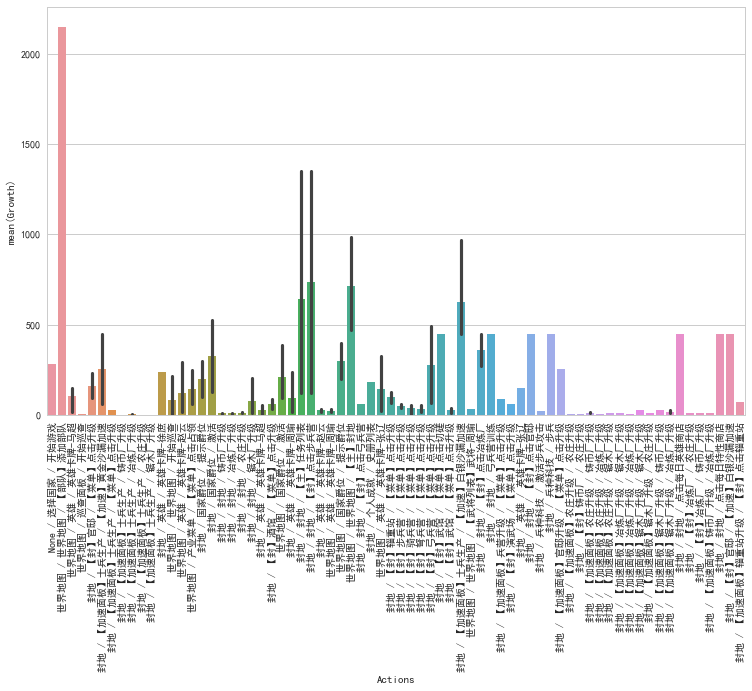

In [14]:
# plt.figure(figsize=(8,4))
# x = single_user["growth"]
# plt.plot(single_user["actions"].values,single_user["growth"].values,color="red",linewidth=2)
# # plt.plot(x,z,"b--",label="$cos(x^2)$")
# plt.show()
sns_plot = sns.barplot(x="Actions", y="Growth", data=result)
plt.xticks(rotation=90)
fig = sns_plot.get_figure()
fig.set_size_inches(12.5, 7.5, forward=True)
fig.savefig("test33.jpg",dpi=1000)


In [10]:
matplotlib.matplotlib_fname()

'/home/maoan/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/matplotlibrc'

In [33]:
result

,Actions,Growth,Times,第几个小时
0,世界地图 / 世界地图 / 【部队】添加部队,2150.0,1.0,0
1,世界地图 / 英雄 / 英雄卡牌-马超,150.0,5.0,0
2,世界地图 / 巡查面板 / 开始巡查,6.0,2.0,0
3,封地 / 【封】官邸 / 【菜单】点击升级,56.0,3.0,0
4,封地 / 【加速面板】士兵生产 / 【加速】黄金沙漏加速,60.0,1.0,0
5,封地 / 【加速面板】士兵生产 / 【菜单】点击升级,25.0,5.0,0
6,封地 / 【加速面板】士兵生产 / 铸币厂升级,1.0,1.0,0
7,封地 / 【加速面板】士兵生产 / 冶炼厂升级,1.0,1.0,0
8,封地 / 【加速面板】士兵生产 / 农庄升级,1.0,1.0,0
9,封地 / 【加速面板】士兵生产 / 锯木厂升级,1.0,1.0,0


In [14]:
np.max([len(i) for i in key_factor_list])

114

In [17]:
len([l[0] for l in key_factor_list if len(l) > 0])

3738

In [18]:
key_factor_list[0]

[[['启动 / 启动 / 3_加载必要资源库', [282, 1]],
  ['世界地图 / 世界地图 / 【部队】添加部队', [2149, 1]],
  ['世界地图 / 英雄 / 英雄卡牌-马超', [131, 4]],
  ['世界地图 / 巡查面板 / 开始巡查', [3, 1]],
  ['封地 / 【封】官邸 / 【菜单】点击升级', [152, 5]],
  ['封地 / 【加速面板】士兵生产 / 【封】点击步兵营', [60, 1]],
  ['封地 / 英雄 / 英雄卡牌-徐庶', [235, 1]],
  ['封地 / 英雄 / 英雄卡牌-马超', [17, 1]],
  ['封地 / 封地 / 锯木厂升级', [8, 4]],
  ['封地 / 封地 / 农庄升级', [15, 8]],
  ['封地 / 封地 / 铸币厂升级', [7, 4]],
  ['封地 / 封地 / 冶炼厂升级', [8, 4]],
  ['世界地图 / 世界地图 / 开始巡查', [35, 10]],
  ['封地 / 国家爵位 / 提示爵位', [100, 1]],
  ['封地 / 国家爵位 / 激活', [18, 1]],
  ['世界地图 / 国家爵位 / 激活', [61, 2]]],
 [['封地 / 封地 / 【封】点击弩兵营', [180, 2]],
  ['封地 / 封地 / 【封】点击弓兵营', [180, 2]],
  ['世界地图 / 世界地图 / 【武将列表】武将-马超', [40, 1]],
  ['世界地图 / 产业菜单 / 【菜单】点击占领', [121, 3]],
  ['世界地图 / 部队 / 【部队】领奖', [3, 1]],
  ['封地 / 封地 / 【封】点击步兵营', [120, 1]],
  ['封地 / 封地 / 农庄升级', [4, 1]],
  ['封地 / 封地 / 锯木厂升级', [4, 1]],
  ['封地 / 封地 / 铸币厂升级', [14, 6]],
  ['封地 / 封地 / 冶炼厂升级', [4, 1]],
  ['封地 / 【封】辎重站 / 【菜单】点击升级', [17, 1]],
  ['封地 / 英雄 / 英雄卡牌-马超', [17, 1]],
  ['封地 / 英雄 / 英雄卡牌-孙

In [235]:
max_continue_hour = np.max([len(i) for i in key_factor_list])
final_df = []

for i in range(max_continue_hour):
#     index_grow_dict = {}
#     index_times_dict = {}
    hour_list = [l[i] for l in key_factor_list if len(l) > i]
    index_growth_list = []
    index_times_list = []
    
    for j in range(len(hour_list)): 
        ulist = hour_list[j]
        index_growth_list.append(dict((ele[0],(ele[1][0],ele[1][1])) for ele in hour_list[j]))

    growth_res = merge_dicts(*index_growth_list)
    pd_dist = pd.DataFrame(list(growth_res.items()), columns=['Action', 'Growth'])
    pd_dist['小时序列'] = i
    pd_dist['指标增长量最大值'] = pd_dist['Growth'].apply(lambda x: np.max([e[0] for e in x]))
    pd_dist['指标增长量最小值'] = pd_dist['Growth'].apply(lambda x: np.min([e[0] for e in x]))
    pd_dist['指标增长量中位数'] = pd_dist['Growth'].apply(lambda x: np.median([e[0] for e in x]))
    pd_dist['指标增长量平均值'] = pd_dist['Growth'].apply(lambda x: np.mean([e[0] for e in x]))
    pd_dist['指标出现次数最大值'] = pd_dist['Growth'].apply(lambda x: np.max([e[1] for e in x]))
    pd_dist['指标出现次数最小值'] = pd_dist['Growth'].apply(lambda x: np.min([e[1] for e in x]))
    pd_dist['指标出现次数中位数'] = pd_dist['Growth'].apply(lambda x: np.median([e[1] for e in x]))
    pd_dist['指标出现次数平均值'] = pd_dist['Growth'].apply(lambda x: np.mean([e[1] for e in x]))
    final_df.append(pd_dist)
    
result = pd.concat(final_df)
result.to_csv("关键指标跟动作的关系.csv", encoding="utf_8",index=False)

        #     print("For Hour {0}".format(i))
#     print("Minimum {0} is {1}".format(index, np.min(hour_list)))
#     print("Maximun {0} is {1}".format(index, np.max(hour_list)))
#     print("Mean {0} is {1:0.2f}".format(index, np.mean(hour_list)))
#     print("Median {0} is {1}".format(index, np.median(hour_list)))
#     print("================================\n")

In [112]:
import datetime
from datetime import timedelta

userlist = uidata['player_id'].unique()
index_list = []
first_day_timestamp = datetime.datetime.strptime("2017-05-18", "%Y-%m-%d").timestamp()
first_date = datetime.datetime.fromtimestamp(first_day_timestamp)
days = 3




In [113]:
print(first_day_timestamp)

1495036800.0


In [114]:
def interval_last(x, begin_date, end_date):
    return x.loc[(x['happen_time'] >begin_date) & (x['happen_time'] < end_date),].tail(1)['total_power'].values

In [115]:
uidata.set_index("player_id", drop=False, inplace=True)

In [116]:
for i in range(days+1):
    num_of_days = timedelta(i)
    interval = first_date + num_of_days
    during_secs = interval.second + 60 * interval.minute + interval.hour * 3600
    begin_date = interval.timestamp() - during_secs
    end_date = interval.timestamp() + (86400 - during_secs)
    print(interval)
    one_interval_list = []
#     update_list = []
    
    inter_data = uidata.groupby('player_id').apply(lambda x : interval_last(x, begin_date, end_date))
    stay_row = inter_data.apply(lambda x : len(x)!=0)
    print(stay_row.sum())
    if stay_row.sum() == 0:
        print("oops...")
        break
    one_interval_list.extend(inter_data.loc[stay_row].apply(lambda x : x[0]).values)
    index_list.append(one_interval_list)
    stay_id = inter_data.loc[stay_row].index
    uidata = uidata.loc[stay_id]
#     for user in userlist:
        
#         udata = uidata.loc[(uidata['player_id'] == user) 
#         & (uidata['happen_time'] >begin_date) & (uidata['happen_time'] < end_date),]
#         if len(udata) > 0:
#             last_index_value = udata.tail(1)['total_power']
#             update_list.append(user)
#             one_interval_list.extend(last_index_value.values)
        
#     if len(update_list) == 0:
#         print("oops...")
#         break
#     index_list.append(one_interval_list)
#     userlist = list(update_list)

2017-05-18 00:00:00
1619
2017-05-19 00:00:00
286
2017-05-20 00:00:00
168
2017-05-21 00:00:00
117


In [29]:
def findMoneyUser(db,money_ulist, step_list):

    dbms = DatabaseManager(db)

    sqlstr = "SELECT player_id, happen_time, subject_class, action, gold FROM maidian ORDER BY player_id,happen_time ASC;"
    data_iterator = dataGen(dbms, sqlstr)

    key_indicator = "开服活动"
    #在规定的步数以内元宝需要增长,才算是付费用户
    step_limt = 10
    #最少充值１００元宝！
    money_limit = 100

    current_player = -1
    origin_money = -1
    find_indicator = False
    steps = -1
    money_user = False
#     money_ulist = []
#     step_list = []
    total_index_dict = collections.defaultdict(list)

    starting_time = time.time()
    counter = 0

    for row in data_iterator:
        counter += 1
        if counter % 1000000 == 0:
            print("%s lines processed\n" % counter)
            # print(timestamp)

        player_id = row[0]
        timestamp = row[1]
        subject_action = row[2]
        action = row[3]
        gold = row[4]

        # 如果更换用户，初始化所有值
        if player_id != current_player:

            find_indicator = False
            money_user = False
            current_player = player_id

        if money_user:
            continue

        if find_indicator and steps <= step_limt:
            steps += 1
            present_money = gold
            if present_money - origin_money >= money_limit:
                money_user = True
                if current_player == 36028840373837154:
                    print("Present Money: {0} - Original Money: {1}. Steps: {2}".format(present_money, origin_money, steps))
                step_list.append(steps)
                money_ulist.append(current_player)
                continue

        if subject_action == key_indicator:
            find_indicator = True
            origin_money = gold
            steps = 0

#     pd.DataFrame({"user":money_ulist, "steps":step_list}).to_csv("moneyU.csv")


In [44]:
def findMoneyUserThroughLists(db,money_ulist, step_list, keyList):

    dbms = DatabaseManager(db)

    sqlstr = "SELECT player_id, happen_time, minor_class, action, gold FROM maidian ORDER BY player_id,happen_time ASC;"
    data_iterator = dataGen(dbms, sqlstr)

    key_indicator = "开服活动"
    #在规定的步数以内元宝需要增长,才算是付费用户
    step_limt = 10
    #最少充值１００元宝！
    money_limit = 100

    current_player = -1
    origin_money = -1
    find_indicator = False
    steps = -1
    money_user = False
#     money_ulist = []
#     step_list = []
    total_index_dict = collections.defaultdict(list)

    starting_time = time.time()
    counter = 0

    for row in data_iterator:
        counter += 1
        if counter % 1000000 == 0:
            print("%s lines processed\n" % counter)
            # print(timestamp)

        player_id = row[0]
        timestamp = row[1]
        subject_action = row[2]
        action = row[3]
        gold = row[4]

        # 如果更换用户，初始化所有值
        if player_id != current_player:

            find_indicator = False
            money_user = False
            current_player = player_id

        if money_user:
            continue

        if find_indicator and steps <= step_limt:
            steps += 1
            present_money = gold
            if present_money - origin_money >= money_limit:
                money_user = True
                if current_player == 36028840373837154:
                    print("Present Money: {0} - Original Money: {1}. Steps: {2}".format(present_money, origin_money, steps))
                step_list.append(steps)
                money_ulist.append(current_player)
                continue

        if sum([1 for e in keyList if e in subject_action]) > 0:
            find_indicator = True
            origin_money = gold
            steps = 0


In [52]:
keyList = ["首充充值","单笔充值5.18","开服累冲5.18","购","礼","总","月卡充值","15充值"]
tlist = ["充值","开服累冲","购","礼","总"]
tstr = "15充值"
sum([1 for e in tlist if e in tstr])

1

In [45]:
db = "/home/maoan/maidianAnalysis/level2-uianalysis/world_seven.db"
money_ulist2 = []
step_list2 = []
findMoneyUserThroughLists(db,money_ulist2,step_list2, tlist)


Present Money: 1338 - Original Money: 638. Steps: 1
1000000 lines processed

2000000 lines processed

3000000 lines processed

4000000 lines processed

5000000 lines processed

6000000 lines processed

7000000 lines processed

8000000 lines processed

9000000 lines processed

10000000 lines processed

11000000 lines processed

12000000 lines processed

13000000 lines processed

14000000 lines processed

15000000 lines processed

16000000 lines processed

17000000 lines processed



In [69]:
[ e for e in money_ulist2 if e not in money_ulist]

[36028840373820832,
 36028840373828503,
 36028840373868291,
 36028840373931318,
 36028840375013360,
 36028840377046073,
 36028840379117751,
 36028840379410010,
 36028840379640250,
 36028840380613238,
 36028840381021682,
 36028840382191280,
 36028840386153410,
 36028840388218304,
 36028840388676958,
 36028840393432029,
 36028840393725781,
 36028840394469474,
 36028840394522559,
 36028840394913716,
 36028840397262115,
 36028840398042787,
 36028840398172563,
 36028840399441738,
 36028840402362123,
 36028840402446596,
 36028840405469739,
 36028840406102118,
 36028840408883388,
 36028840408961794,
 36028840411981731,
 36028840414423584,
 36028840416052739,
 36028840416396643,
 36028840417782834,
 36028840460673165,
 36028840465907698,
 36028840466215868,
 36028840470641883,
 36028840472046289,
 36028840481231293,
 36028840486218296,
 36028840487118036,
 36028840501478697,
 36028840516900298,
 36028840538399189,
 36028840682854769,
 36028840743780288,
 72057637392772917,
 72057637392774944,


In [47]:
len(step_list2)

1746

In [30]:
db = "/home/maoan/maidianAnalysis/level2-uianalysis/world_seven.db"
money_ulist = []
step_list = []
findMoneyUser(db,money_ulist,step_list)


Present Money: 1491 - Original Money: 1391. Steps: 10
1000000 lines processed

2000000 lines processed

3000000 lines processed

4000000 lines processed

5000000 lines processed

6000000 lines processed

7000000 lines processed

8000000 lines processed

9000000 lines processed

10000000 lines processed

11000000 lines processed

12000000 lines processed

13000000 lines processed

14000000 lines processed

15000000 lines processed

16000000 lines processed

17000000 lines processed



In [22]:
tt = pd.DataFrame({"user":money_ulist, "steps":step_list})

### 找到付费用户

In [184]:
def findMoneyUser(db):

    dbms = DatabaseManager(db)
    keyList = ["充值", "开服累冲", "购", "礼", "总"]

    sqlstr = "SELECT player_id, happen_time, minor_class, action, gold FROM maidian ORDER BY player_id,happen_time ASC;"
    data_iterator = dataGen(dbms, sqlstr)

    key_indicator = "开服活动"
    #在规定的步数以内元宝需要增长,才算是付费用户
    step_limt = 10
    #最少充值１００元宝！
    money_limit = 100

    current_player = -1
    origin_money = -1
    find_indicator = False
    steps = -1
    money_user = False
    money_ulist = []
    step_list = []
    total_index_dict = collections.defaultdict(list)

    starting_time = time.time()
    counter = 0

    for row in data_iterator:
        counter += 1
        if counter % 1000000 == 0:
            print("%s lines processed\n" % counter)
            # print(timestamp)

        player_id = row[0]
        timestamp = row[1]
        subject_action = row[2]
        action = row[3]
        gold = row[4]

        # 如果更换用户，初始化所有值
        if player_id != current_player:

            find_indicator = False
            money_user = False
            current_player = player_id

        if money_user:
            continue

        if find_indicator and steps <= step_limt:
            steps += 1
            present_money = gold
            if present_money - origin_money >= money_limit:
                money_user = True
                # print("Present Money: {0} - Original Money: {1}. Steps: {2}".format(present_money, origin_money, steps))
                step_list.append(steps)
                money_ulist.append(current_player)
                continue

        if sum([1 for e in keyList if e in subject_action]) > 0:
            find_indicator = True
            origin_money = gold
            steps = 0

# pd.DataFrame({"user":money_ulist, "steps":step_list}).to_csv("moneyU.csv")
    return pd.DataFrame({"user":money_ulist, "steps":step_list})

In [185]:
moneyU = findMoneyUser(db)

1000000 lines processed

2000000 lines processed

3000000 lines processed

4000000 lines processed

5000000 lines processed

6000000 lines processed

7000000 lines processed

8000000 lines processed

9000000 lines processed

10000000 lines processed

11000000 lines processed

12000000 lines processed

13000000 lines processed

14000000 lines processed

15000000 lines processed

16000000 lines processed

17000000 lines processed



In [186]:
moneyU

,steps,user
0,1,36028840373808717
1,1,36028840373811787
2,3,36028840373812793
3,1,36028840373815496
4,11,36028840373820832
5,1,36028840373821676
6,2,36028840373828503
7,1,36028840373837154
8,4,36028840373844026
9,1,36028840373854290


### 用户点击频率

In [177]:
def clickFrequency(db):

    dbms = DatabaseManager(db)

    sqlstr = "SELECT player_id, happen_time, major_class FROM maidian ORDER BY player_id,happen_time ASC;"
    data_iterator = dataGen(dbms, sqlstr)

    #如果两次动作的间隔时间大于３００秒，算两次连续动作
    interval_limit = 300
    first_action_time = -1
    last_action_time = -1
    times = -1.
    current_player = -1
    freq_list = []
    total_index_dict = collections.defaultdict(list)

    starting_time = time.time()
    counter = 0

    for row in data_iterator:
        counter += 1
        if counter % 1000000 == 0:
            print("%s lines processed\n" % counter)
            # print(timestamp)

        player_id = row[0]
        timestamp = row[1]
        major_action = row[2]


#         ## 如果在启动阶段，用户的关键指标可能是０，因为需要从服务器取得数据。所以忽略。
#         if major_action == None or major_action == "启动":
#             continue

        # 如果更换用户，初始化所有值
        if player_id != current_player:


            ##有的用户只有一次连续操作的时间段
            if len(freq_list) == 0:
                diff = last_action_time - first_action_time
                if diff != 0:
                    freq = times / diff
                    freq_list.append(freq)

            if current_player != -1:
                total_index_dict[current_player] = np.median(freq_list)

            first_action_time = timestamp
            last_action_time = timestamp
            freq_list = []
            times = -1.
            current_player = player_id
            # print("================")
#         if player_id == 36028840385154595:

#             print("last " + str(last_action_time))
#             print("first " + str(first_action_time))
#             print("now " + str(timestamp))

        if timestamp - last_action_time > interval_limit:

            diff = last_action_time - first_action_time
            ## 连续时间必须大于５分钟才加入计算
            if diff >= 300:
                freq = times / diff
                freq_list.append(freq)

            first_action_time = timestamp
            times = -1.

        times += 1
        last_action_time = timestamp

    ##有的用户只有一次连续操作的时间段
    if len(freq_list) == 0:
        diff = last_action_time - first_action_time
        if diff != 0:
            freq = times / diff
            freq_list.append(freq)


    total_index_dict[current_player] = np.median(freq_list)
        
    pd_dist = pd.DataFrame(list(total_index_dict.items()), columns=['Player', 'Freq'])

    return pd_dist


In [178]:
db = "/home/maoan/maidianAnalysis/level2-uianalysis/world_seven.db"
freq = clickFrequency(db)

/home/maoan/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/maoan/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1000000 lines processed

2000000 lines processed

3000000 lines processed

4000000 lines processed

5000000 lines processed

6000000 lines processed

7000000 lines processed

8000000 lines processed

9000000 lines processed

10000000 lines processed

11000000 lines processed

12000000 lines processed

13000000 lines processed

14000000 lines processed

15000000 lines processed

16000000 lines processed

17000000 lines processed



In [183]:
freq.loc[freq['Player'].isin(moneyU['user']),]

NameError: name 'moneyU' is not defined

In [27]:
moneyU['user'].shape

(1746,)

In [187]:
freq['money'] = freq['Player'].isin(moneyU['user'])
# freq['Player'] = freq['Player'].apply(lambda x : int(x))

In [188]:
freq

,Player,Freq,money
0,36028840373795443,0.165793,False
1,36028840373806493,0.398864,False
2,36028840373807939,0.222622,False
3,36028840373808717,0.165294,True
4,36028840373810279,0.264029,False
5,36028840373811787,0.119057,True
6,36028840373812793,0.120133,True
7,36028840373815496,0.118325,True
8,36028840373820832,0.109736,True
9,36028840373821676,0.149510,True


In [189]:
resDF['Freq'] = freq['Freq']

In [190]:
resDF['Money'] = freq['money']

In [191]:
resDF

,Player,Duration,Loss,Freq,Money
0,36028840373795443,[10528],True,0.165793,False
1,36028840373806493,[1409],False,0.398864,False
2,36028840373807939,[4336],False,0.222622,False
3,36028840373808717,[26341],True,0.165294,True
4,36028840373810279,[3617],True,0.264029,False
5,36028840373811787,[18328],True,0.119057,True
6,36028840373812793,[21592],True,0.120133,True
7,36028840373815496,[35327],True,0.118325,True
8,36028840373820832,[23493],False,0.109736,True
9,36028840373821676,[26054],True,0.149510,True


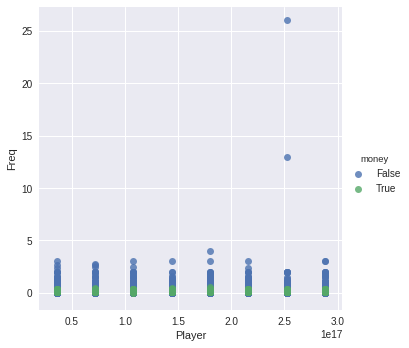

In [45]:
sns.lmplot(x='Player', y='Freq', data=freq,
           fit_reg=False, # No regression line
           hue='money')   # Color by evolution stage

In [46]:
freq.groupby("money")['Freq'].describe()

money       
False  count    13589.000000
       mean         0.200357
       std          0.351263
       min          0.004673
       25%          0.073684
       50%          0.125000
       75%          0.200000
       max         26.000000
True   count     1746.000000
       mean         0.167102
       std          0.061735
       min          0.015481
       25%          0.123240
       50%          0.157164
       75%          0.197451
       max          0.574050
Name: Freq, dtype: float64

In [47]:
(freq["money"] == True).sum()

1746

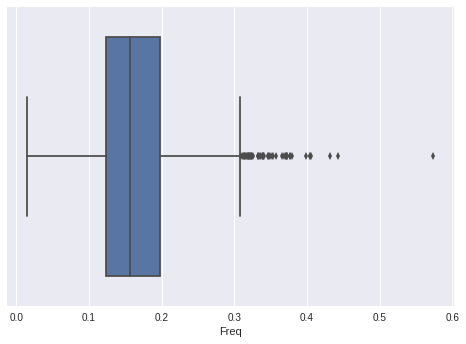

In [48]:
sns.boxplot(freq.loc[freq["money"],]['Freq'])

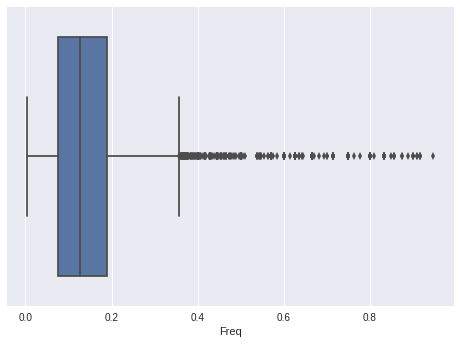

In [52]:
sns.boxplot(freq.loc[freq["Freq"]<1,]['Freq'])

In [53]:
freq.shape[0]

15335

### 用户一天的游戏时间

In [92]:
def numOfRecords(x,begin_date, end_date):

    interval = x.loc[(x['happen_time'] >begin_date) & (x['happen_time'] < end_date),'happen_time']
    return (interval.tail(1).values - interval.head(1).values)

def timePlayOneDay(db, first_day_timestamp, days):

    conn = sqlite3.connect(db)
    sqlstr = "SELECT happen_time, player_id FROM maidian ORDER BY player_id,happen_time ASC;"
    indexDF = pd.read_sql_query(sqlstr, conn)

    userlist = indexDF['player_id'].unique()
    print("Total Users: " + str(len(userlist)))
    index_list = []
#     indexDF.set_index("player_id", drop=False, inplace=True)

    intervalGen = IntervalGenerator(first_day_timestamp, days=days)

    final_df =[]
    ## 对于指定的N天内，循环每一天用户的指标成长情况。如果有不连续的情况，则忽略。
    for ig in intervalGen.daysGenerator():
        begin_date = ig.begin_interval
        end_date = ig.end_interval
        print(
            "Begin From {0} - To {1}".format(datetime.fromtimestamp(begin_date), datetime.fromtimestamp(end_date)))
        one_interval_list = []

        inter_data = indexDF.groupby('player_id').apply(lambda x: numOfRecords(x, begin_date, end_date))
        print(inter_data.head(5))
        
        inter_data = inter_data.reset_index(level=['player_id'])
        final_df.append(inter_data)

    result = pd.concat(final_df)
    return result

In [19]:
def latestPlayDate(db):

    dbms = DatabaseManager(db)

    sqlstr = "SELECT player_id, happen_time FROM maidian ORDER BY player_id,happen_time ASC;"
    data_iterator = dataGen(dbms, sqlstr)
    
    latestDate = -1
    player = -1
    
    counter = 0
    # dist = collections.defaultdict(int)
    print("Enter!")
    for row in data_iterator:
        counter += 1
        if counter % 1000000 == 0:
            print("%s lines processed\n" % counter)
            # print(timestamp)
        
        player_id = row[0]
        timestamp = row[1]
        
        if timestamp > latestDate:
            latestDate = timestamp
            player = player_id
    
    print("Latest Player {0} - Time:{1}".format(player, latestDate))
    

In [47]:
def firstNonZeroTime(x):
    return x.loc[x['Duration']!=0,'Duration'].head(1).values

In [3]:

##在给定的日期内,算出连续操作的时间段的和
def realPlayTime(timeList, begin_date, end_date, threshold = 300):

    during_time = 0
    truncL = [t for t in timeList if t <= end_date and t >= begin_date]
    if len(truncL) == 0:
        return during_time
    
    begin_time = truncL[0]
    last_time = begin_time
    for t in truncL:

        if t - last_time > threshold:
            during_time += (last_time - begin_time)
            begin_time = t

        last_time = t

    during_time += (last_time - begin_time)

    return during_time

def timePlayOneDay(db, begin_date, end_date, threshold):

    dbms = DatabaseManager(db)

    sqlstr = "SELECT player_id, happen_time, major_class FROM maidian ORDER BY player_id,happen_time ASC;"
    data_iterator = dataGen(dbms, sqlstr)

    current_player = -1
#     total_index_dict = collections.defaultdict(list)
    timeDict = {}
    during_time = 0

    counter = 0
    # dist = collections.defaultdict(int)
    print("Enter!")
    for row in data_iterator:
        counter += 1
        if counter % 1000000 == 0:
            print("%s lines processed\n" % counter)
            # print(timestamp)

        player_id = row[0]
        timestamp = row[1]
        major_action = row[2]
        if player_id != current_player:
            
            if current_player != -1:
                during_time += (last_time - begin_time)
                timeDict[current_player] = during_time
                
            begin_time = timestamp
            last_time = timestamp

            during_time = 0
            current_player = player_id

        if timestamp > end_date or timestamp < begin_date:
            continue
            
#         ## 如果在启动阶段，用户的关键指标可能是０，因为需要从服务器取得数据。所以忽略。
#         if major_action == None or major_action == "启动":
#             continue
        
        if timestamp - last_time > threshold:
            during_time += (last_time - begin_time)
            begin_time = timestamp

        last_time = timestamp

    during_time += (last_time - begin_time)
    timeDict[current_player] = during_time
    pd_dist = pd.DataFrame(list(timeDict.items()), columns=['Player', 'Duration'])
    
    return pd_dist

In [6]:
new_date = datetime.strptime("2017-05-18", "%Y-%m-%d")

intervalGen = IntervalGenerator(new_date.timestamp(), days=3)
final_df = []
for ig in intervalGen.daysGenerator():
    begin_date = ig.begin_interval
    end_date = ig.end_interval
    dayOneDF = timePlayOneDay(db,begin_date,end_date, 300)
    final_df.append(dayOneDF)

result = pd.concat(final_df)

Enter!
1000000 lines processed

2000000 lines processed

3000000 lines processed

4000000 lines processed

5000000 lines processed

6000000 lines processed

7000000 lines processed

8000000 lines processed

9000000 lines processed

10000000 lines processed

11000000 lines processed

12000000 lines processed

13000000 lines processed

14000000 lines processed

15000000 lines processed

16000000 lines processed

17000000 lines processed

Enter!
1000000 lines processed

2000000 lines processed

3000000 lines processed

4000000 lines processed

5000000 lines processed

6000000 lines processed

7000000 lines processed

8000000 lines processed

9000000 lines processed

10000000 lines processed

11000000 lines processed

12000000 lines processed

13000000 lines processed

14000000 lines processed

15000000 lines processed

16000000 lines processed

17000000 lines processed

Enter!
1000000 lines processed

2000000 lines processed

3000000 lines processed

4000000 lines processed

5000000 lines

In [76]:
def lossUsers(x):
    return x.loc[x['Duration'] > 0,'Duration'].count()

In [312]:
lossu = result.groupby("Player").apply(lambda x: lossUsers(x))

In [302]:
lossu = lossu.reset_index(level=['Player'])


In [304]:
lossu.rename(columns={0: 'Count'}, inplace=True)

In [305]:
lossu['Loss'] = lossu['Count'] > 1

In [313]:
resDF = lossu.to_frame("Count")
# resDF['Duration'] = tt

In [316]:
resDF

,Player,Count,Loss
0,36028840373795443,2,True
1,36028840373806493,1,False
2,36028840373807939,1,False
3,36028840373808717,2,True
4,36028840373810279,2,True
5,36028840373811787,4,True
6,36028840373812793,4,True
7,36028840373815496,4,True
8,36028840373820832,1,False
9,36028840373821676,4,True


In [195]:
result[result['Player'] == 288230419995301622]

,Player,Duration
17377,288230419995301622,0
17377,288230419995301622,0
17377,288230419995301622,0
17377,288230419995301622,0


In [315]:
# resDF = resDF[resDF['Duration'].apply(lambda x: len(x) != 0)]
# resDF['Duration'] = resDF['Duration'].apply(lambda x: x[0])
resDF = resDF.reset_index()
resDF['Loss'] = resDF['Count'] > 1

In [163]:
resDF.drop('Count', axis=1,inplace=True)

In [164]:
resDF

,Player,Duration,Loss
0,36028840373795443,[10528],True
1,36028840373806493,[1409],False
2,36028840373807939,[4336],False
3,36028840373808717,[26341],True
4,36028840373810279,[3617],True
5,36028840373811787,[18328],True
6,36028840373812793,[21592],True
7,36028840373815496,[35327],True
8,36028840373820832,[23493],False
9,36028840373821676,[26054],True


In [49]:
tt = result.groupby("Player").apply(lambda x: firstNonZeroTime(x))

In [95]:
## 1%的用户玩的时间很少，应该只点击了一两次左右，删掉
tt.apply(lambda x: len(x)==0).sum()/tt.shape[0]

0.014321868169791786

In [171]:
tt.shape

(17386,)

In [67]:
stayUsers = tt[tt.apply(lambda x: len(x) != 0)].apply(lambda x:x[0])
stayUsers = stayUsers.reset_index(level=['Player'])

In [71]:
stayUsers.rename(columns={0: 'Duration'}, inplace=True)

In [72]:
stayUsers

,Player,Duration
0,36028840373795443,10528
1,36028840373806493,1409
2,36028840373807939,4336
3,36028840373808717,26341
4,36028840373810279,3617
5,36028840373811787,18328
6,36028840373812793,21592
7,36028840373815496,35327
8,36028840373820832,23493
9,36028840373821676,26054


In [28]:
new_date = datetime.strptime("2017-05-18", "%Y-%m-%d")

intervalGen = IntervalGenerator(new_date.timestamp(), days=3)
final_df = []
for ig in intervalGen.daysGenerator():
    begin_date = ig.begin_interval
    end_date = ig.end_interval
    print(
            "Begin From {0} - To {1}".format(begin_date, end_date))

Begin From 1495036800.0 - To 1495123200.0
Begin From 1495123200.0 - To 1495209600.0
Begin From 1495209600.0 - To 1495296000.0
Begin From 1495296000.0 - To 1495382400.0


In [24]:
(datetime.fromtimestamp(1495617135) - new_date).days

6

In [26]:
datetime.fromtimestamp(1495617135)

datetime.datetime(2017, 5, 24, 17, 12, 15)

### 玩法停留时间

In [214]:

## 分离比较ACTION的逻辑
def compareAction(user_action, action_list, auto=False):

    if not auto:
        if user_action in action_list:
            return True
        else:
            return False
    else:
        if user_action not in action_list:
            return True
        else:
            return False

def ui_stay_time(in_action, out_action, data_iterator, loss_window = 20):

    time_of_normal_stay = 0
    time_of_total_stay = 0

    stay_limit = 1500
    num_enter = 0
    num_of_correct_exit = 0

    current_player = -1

    find_flag = False
    correct_exit = True
    window_len = 0

    starting_time = time.time()
    counter = 0

    enter_time = 0
    total_exit_time = 0

    stay_time = 0
    duringDict = {}

    for row in data_iterator:

        counter += 1
        if counter % 1000000 == 0:
            print("%s lines processed\n" % counter)
            # print("total enter:" + str(num_enter))
            # print("correct exit :" + str(num_of_correct_exit))


        player_id = row[0]
        # 如果更换用户，初始化所有值，并且计算上一个用户的所有以及正确的停留的时间。
        if player_id != current_player:
            find_flag = False
            window_len = 0
            correct_exit = True
            # 如果没有进入时间，则忽略计算。否则，判断下是否有整体退出时间。
#             if enter_time != 0:
#                 stay_time = (total_exit_time - enter_time)
#                 duringDict[current_player] = stay_time
#             else:
#                 duringDict[current_player] = 0
            if current_player != -1:
                stay_time = (total_exit_time - enter_time)
                duringDict[current_player] = stay_time

            current_player = player_id

            enter_time = 0
            total_exit_time = 0
            stay_time = 0

        action = row[2]
        timestamp = row[1]

#         if major_action == None or major_action == "启动":
#             continue

        # 如果被标记，该用户所有剩余action都忽略
        if not correct_exit:
            continue

        # 如果对某一个用户，第一次找到相应的进入UI动作，记录总人数加一并标记。记录进入时间
        if (compareAction(action, in_action) and (not find_flag)):
            find_flag = True
            enter_time = timestamp
            total_exit_time = timestamp
            num_enter += 1
            continue

        # 如果已找到进入动作，判断此时动作是否为退出动作。如果是，正确退出加一，否则判断窗口长度是否大于
        # 标准值，如果是的话，此用户记录为非正常退出，并记录时间
        if find_flag:
            if compareAction(action, out_action):
                num_of_correct_exit += 1
                total_exit_time = timestamp
                correct_exit = False
            else:
                window_len += 1
                if window_len >= loss_window and (timestamp - enter_time) < stay_limit:
                    correct_exit = False
                    total_exit_time = timestamp
                if (timestamp - enter_time) > stay_limit:
                    correct_exit = False
                    total_exit_time = enter_time
                    
    stay_time = (total_exit_time - enter_time)
    duringDict[current_player] = stay_time

    pd_dist = pd.DataFrame(list(duringDict.items()), columns=['Player', 'TimeOnUI'])


    return pd_dist

In [215]:
enter_action = "UIRoot2D/ModalPanel/TeamEditWin/Btn_Start"
exit_action = "UIRoot2D/NormalPanel/BattleSettlementWin/Img_Bg/Go_Btn/Btn_Quit"
# dbms = DatabaseManager(db)
# query_sql = "SELECT player_id,action,happen_time, major_class FROM maidian ORDER BY player_id,happen_time ASC"
sqls = "SELECT yonghu_id, timestamp, action FROM maidian ORDER BY yonghu_id,timestamp ASC;"

ustay = ui_stay_time(enter_action,exit_action, dataGen(db4,sqls))

1000000 lines processed

2000000 lines processed

3000000 lines processed

4000000 lines processed

5000000 lines processed

6000000 lines processed

7000000 lines processed

8000000 lines processed



In [217]:
ustay

,Player,TimeOnUI
0,1039,178
1,1263,132
2,2985,0
3,4421,114
4,6316,133
5,6435,0
6,8165,158
7,8614,0
8,8857,118
9,10532,74


In [216]:
(ustay['TimeOnUI'] != 0).sum()

3005

In [28]:
plot_df.index

Int64Index([   0,    1,    2,    4,    5,    6,    7,    8,    9,   10,
            ...
            1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641],
           dtype='int64', length=1467)

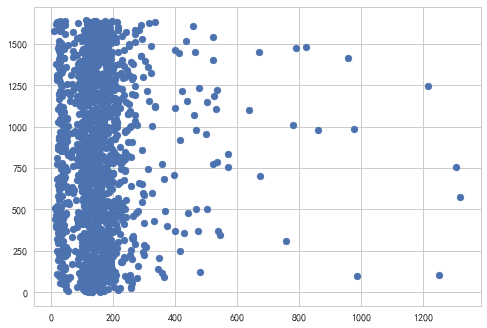

In [31]:
plot_df = ustay.loc[ustay['TimeOnUI']!=0,'TimeOnUI']
fig, ax = plt.subplots()
# ax.plot(res.loc[res['Level']<=30,'指标消耗量-中位数']/res.loc[res['Level']<=30,'指标留存值-中位数'],label='厦门')#绘制线
# ax.plot(kuangbao.loc[kuangbao['Level']<=30,'指标消耗量-中位数']/kuangbao.loc[kuangbao['Level']<=30,'指标留存值-中位数'],label='狂暴之翼')

ax.scatter(plot_df,plot_df.index)
# ax.plot(kuangbao['指标消耗量-中位数']/kuangbao['指标留存值-中位数'],label='狂暴之翼')
# plt.plot(plot_df,)

In [23]:
ustay.loc[ustay['TimeOnUI']!=0,'TimeOnUI']

count    1467.000000
mean      154.107021
std       116.685899
min        11.000000
25%       106.000000
50%       138.000000
75%       182.000000
max      1319.000000
Name: TimeOnUI, dtype: float64

In [282]:
resDF['TimeOnUI'] = ustay['TimeOnUI']

In [283]:
resDF

,Player,Duration,Loss,Freq,Money,TimeOnUI
0,36028840373795443,[10528],True,0.165793,False,3
1,36028840373806493,[1409],False,0.398864,False,6
2,36028840373807939,[4336],False,0.222622,False,5
3,36028840373808717,[26341],True,0.165294,True,4
4,36028840373810279,[3617],True,0.264029,False,5
5,36028840373811787,[18328],True,0.119057,True,4
6,36028840373812793,[21592],True,0.120133,True,3
7,36028840373815496,[35327],True,0.118325,True,3
8,36028840373820832,[23493],False,0.109736,True,4
9,36028840373821676,[26054],True,0.149510,True,4


In [281]:
ustay

,Player,TimeOnUI
0,36028840373795443,3
1,36028840373806493,6
2,36028840373807939,5
3,36028840373808717,4
4,36028840373810279,5
5,36028840373811787,4
6,36028840373812793,3
7,36028840373815496,3
8,36028840373820832,4
9,36028840373821676,4


In [92]:

def indexChangeCumul(db, sqlstr, **kw):

    dbms = DatabaseManager(db)

    # sqlstr = "SELECT yonghu_id, " + intex + ", timestamp FROM maidian ORDER BY yonghu_id,timestamp ASC;"
    data_iterator = dataGen(dbms, sqlstr)
    changeF = 1

    if 'changeF' in kw:
        changeF = -1

    current_player = -1
    #     total_index_dict = collections.defaultdict(list)
    timeDict = {}
    cumulative_index = 0

    counter = 0
    # dist = collections.defaultdict(int)
    print("Enter!")
    for row in data_iterator:
        counter += 1
        if counter % 1000000 == 0:
            print("%s lines processed\n" % counter)
            # print(timestamp)

        player_id = row[0]
        timestamp = row[1]
        key_factor = row[2]

        if player_id != current_player:

            if current_player != -1:
                timeDict[current_player] = cumulative_index

            last_key_value = key_factor
            cumulative_index = 0
            current_player = player_id

#         if timestamp > end_date or timestamp < begin_date:
#             continue

        # ## 如果在启动阶段，用户的关键指标可能是０，因为需要从服务器取得数据。所以忽略。
        #         if major_action == None or major_action == "启动":
        #             continue

        if (key_factor-last_key_value) * changeF > 0:
            diff = (key_factor-last_key_value) * changeF

            cumulative_index += diff

        last_key_value = key_factor

    timeDict[current_player] = cumulative_index
    pd_dist = pd.DataFrame(list(timeDict.items()), columns=['Player', 'CumulativeChange'])

#     name = "金币减少.xlsx"
#     pd_dist.to_excel(name,'Sheet1',index=False, engine='xlsxwriter')

    return pd_dist

In [97]:
dbcol.columns

Index(['ObjectID', 'yonghu_id', 'wanjia_id', 'ip', 'shebei', 'qudao',
       'timestamp', 'action', 'duiwu_level', 'duiwu_experience',
       'duiwu_zhanli', 'vip_level', 'vip_experience', 'ugc_credits',
       'ugc_castle_level', 'ugc_castle_experience', 'jinbi', 'zuanshi',
       'shuijing', 'tili', 'jingli', 'shiyou', 'mojingshi', 'hero_peiyang_shi',
       'hero_tupo_shi', 'exp_book_1_amount', 'exp_book_2_amount',
       'exp_book_3_amount', 'exp_book_4_amount', 'RESOURCE_UNKNOWN',
       'hero_info'],
      dtype='object')

In [199]:
sql_xiamen_jinbi_drop = "SELECT yonghu_id, timestamp, zuanshi FROM maidian ORDER BY yonghu_id,timestamp ASC;"
# db3= "/home/maoan/maidianAnalysis/xiamen/1308310007.db"
sql_kuangbao_index_drop = "SELECT user_id, riqi, zuanshi FROM maidian ORDER BY user_id,riqi ASC;"
gold = indexChangeCumul(db=db3,sqlstr=sql_kuangbao_index_drop,changeF=-1)
gold_xiamen = indexChangeCumul(db=db2,sqlstr=sql_xiamen_jinbi_drop,changeF=-1)


Enter!
1000000 lines processed

2000000 lines processed

3000000 lines processed

4000000 lines processed

5000000 lines processed

6000000 lines processed

7000000 lines processed

8000000 lines processed

9000000 lines processed

10000000 lines processed

11000000 lines processed

12000000 lines processed

13000000 lines processed

14000000 lines processed

15000000 lines processed

16000000 lines processed

17000000 lines processed

18000000 lines processed

19000000 lines processed

20000000 lines processed

21000000 lines processed

22000000 lines processed

23000000 lines processed

Enter!
1000000 lines processed

2000000 lines processed

3000000 lines processed

4000000 lines processed

5000000 lines processed

6000000 lines processed

7000000 lines processed

8000000 lines processed



In [185]:
(gold['CumulativeChange'] == 0).sum()

3867

In [107]:
gold.loc[gold['CumulativeChange'] !=0,].to_excel("魔晶石减少.xlsx",'Sheet1',index=False, engine='xlsxwriter')

In [200]:
plot_df = gold.loc[gold['CumulativeChange'] !=0,'CumulativeChange']

In [201]:
plot_df_xiamen = gold_xiamen.loc[gold['CumulativeChange'] !=0,'CumulativeChange']

In [187]:
gold.describe()

,Player,CumulativeChange
count,1.800500e+04,1.800500e+04
mean,9.106956e+07,1.181023e+06
std,5.264839e+07,2.994654e+06
min,1.001000e+04,0.000000e+00
25%,4.544001e+07,4.510000e+03
50%,9.111001e+07,7.844000e+04
75%,1.365400e+08,8.498540e+05
max,1.995500e+08,6.142027e+07


In [192]:
plot_df.loc[plot_df == plot_df.max(),]

1589    55809584
Name: CumulativeChange, dtype: int64

In [191]:
plot_df.drop(6,inplace=True)

/home/maoan/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


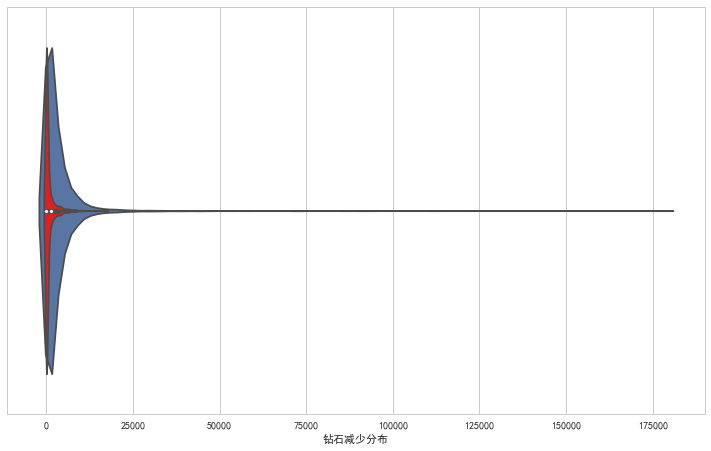

In [202]:
te = sns.violinplot(plot_df,inner="box")
te = sns.violinplot(plot_df_xiamen,inner="box",color='r')

# te = sns.swarmplot(plot_df)
te.set(xlabel="钻石减少分布")
fig = te.get_figure()
fig.set_size_inches(12.5, 7.5, forward=True)
fig.savefig("金币减少分布－对比.png")
fig.show()


### 第一次接触某元素的时间

In [273]:
def firstGetMoney(db):

    current_player = -1
    
    dbms = DatabaseManager(db)

    sqlstr = "SELECT player_id, happen_time, minor_class FROM maidian ORDER BY player_id,happen_time ASC;"
    data_iterator = dataGen(dbms, sqlstr)

    keyList = ["充值", "开服累冲", "购", "礼", "总"]
    find_flag = False
    correct_exit = True

    starting_time = time.time()
    
    counter = 0

    enter_time = 0
    first_access_time = 0

    stay_time = 0
    accessDict = {}

    for row in data_iterator:

        counter += 1
        if counter % 1000000 == 0:
            print("%s lines processed\n" % counter)
            # print("total enter:" + str(num_enter))
            # print("correct exit :" + str(num_of_correct_exit))


        player_id = row[0]
        timestamp = row[1]
        minor_action = row[2]
        
        # 如果更换用户，初始化所有值，并且计算上一个用户的所有以及正确的停留的时间。
        if player_id != current_player:
            
            if first_access_time > 0:
                stay_time = first_access_time - enter_time
            
            if current_player != -1:
                accessDict[current_player] = stay_time

            enter_time = timestamp
            stay_time = 0
            find_flag = False
            first_access_time = 0
            current_player = player_id

            

        # 如果被标记，该用户所有剩余action都忽略
        if find_flag:
            continue

        # 如果对某一个用户，看是否是充值活动,记录进入时间
        if sum([1 for e in keyList if e in minor_action]) > 0:
            find_flag = True
            first_access_time = timestamp
            continue

       
                    
    if first_access_time > 0:
        stay_time = first_access_time - enter_time
    accessDict[current_player] = stay_time
    
    pd_dist = pd.DataFrame(list(accessDict.items()), columns=['Player', 'Time'])


    return pd_dist

In [274]:
firstMoney = firrstGetMoney(db)

1000000 lines processed

2000000 lines processed

3000000 lines processed

4000000 lines processed

5000000 lines processed

6000000 lines processed

7000000 lines processed

8000000 lines processed

9000000 lines processed

10000000 lines processed

11000000 lines processed

12000000 lines processed

13000000 lines processed

14000000 lines processed

15000000 lines processed

16000000 lines processed

17000000 lines processed



In [286]:
firstMoney

,Player,Time
0,36028840373795443,8066
1,36028840373806493,0
2,36028840373807939,293
3,36028840373808717,475
4,36028840373810279,1258
5,36028840373811787,539
6,36028840373812793,292
7,36028840373815496,385
8,36028840373820832,1006
9,36028840373821676,353


In [287]:
resDF['FirstTime'] = firstMoney['Time']

In [288]:
resDF

,Player,Duration,Loss,Freq,Money,TimeOnUI,FirstTime
0,36028840373795443,[10528],True,0.165793,False,3,8066
1,36028840373806493,[1409],False,0.398864,False,6,0
2,36028840373807939,[4336],False,0.222622,False,5,293
3,36028840373808717,[26341],True,0.165294,True,4,475
4,36028840373810279,[3617],True,0.264029,False,5,1258
5,36028840373811787,[18328],True,0.119057,True,4,539
6,36028840373812793,[21592],True,0.120133,True,3,292
7,36028840373815496,[35327],True,0.118325,True,3,385
8,36028840373820832,[23493],False,0.109736,True,4,1006
9,36028840373821676,[26054],True,0.149510,True,4,353


In [317]:
profile = pd.read_csv("/home/maoan/maidianAnalysis/level2-uianalysis/用户画像.csv")

In [340]:
cols = profile.columns.tolist()
# cols = cols[-1:] + cols[:-1]


In [341]:
cols

['用户', '第一天游戏时间', '是否流失', '是否付费玩家', '点击频率', '首次尝试付费时间', '指定UI/玩法停留时间']

In [342]:
new_cols = cols[:2] + cols[4:] + cols[2:4]

In [343]:
profile = profile[new_cols]

In [337]:
profile.rename(columns={'Player': '用户','Duration':'第一天游戏时间',
                        'Freq':'点击频率','FirstTime':'首次尝试付费时间',
                       'TimeOnUI':'指定UI/玩法停留时间','Money':'是否付费玩家','Loss':'是否流失'}, inplace=True)

In [345]:
profile.to_csv("用户画像.csv",index=False)

### 建模

In [4]:
from sklearn import tree
from sklearn.tree import  export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")


In [60]:
profile = pd.read_csv("/home/maoan/maidianAnalysis/level2-uianalysis/用户画像.csv")

In [61]:
profile.columns

Index(['Player', 'Duration', 'Loss', 'Money', 'Freq', 'FirstTime', 'TimeOnUI'], dtype='object')

In [7]:
clf = tree.DecisionTreeClassifier()

In [18]:
str(clf).split("(")[0]

'DecisionTreeClassifier'

In [62]:
features = profile.columns[1:2].tolist() + profile.columns[4:].tolist()

In [13]:
profile.dropna(axis=0, how='any',inplace=True)

In [15]:
y = profile["Loss"].as_matrix()
X = profile[features].as_matrix()
kf = KFold(n_splits=10)
skf = StratifiedKFold(n_splits=6)

min_split=20
max_dep=3
dt = tree.DecisionTreeClassifier(min_samples_split=min_split, max_depth=max_dep)
print("Decision Tree has been established with the 'min_samples_split':{0},'max_depth':{1}".format(min_split,max_dep))

lr = LogisticRegression(penalty='l1')
for train_index, test_index in skf.split(X,y):
#     print("TRAIN:",train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    print("10-fold Score is: {0}".format(score))

# Compute confusion matrix
# 
#

Decision Tree has been established with the 'min_samples_split':20,'max_depth':3
10-fold Score is: 0.8857242097950677
10-fold Score is: 0.8815560958666203
10-fold Score is: 0.8843348384855853
10-fold Score is: 0.8867662382771796
10-fold Score is: 0.8867662382771796
10-fold Score is: 0.8780403057678944


In [141]:
features

['Duration', 'Freq', 'FirstTime', 'TimeOnUI', '1hour']

In [139]:
lr.coef_

array([[ 0. ,  0.1,  0. ,  0. ,  0. ]])

Confusion matrix, without normalization
[[2332   39]
 [ 312  195]]


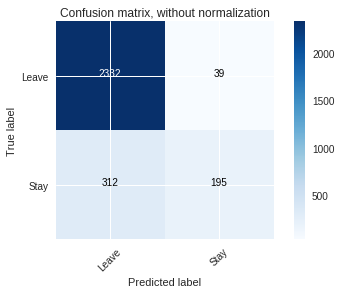

In [16]:
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
class_names = ['Leave','Stay']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()


In [135]:
visualize_tree(dt,features)

In [62]:
y = profile["Loss"].as_matrix()
y[train_index]

array([False,  True, False, ..., False, False, False], dtype=bool)

In [113]:
profile.groupby("Loss").describe()

Duration      FirstTime          Freq        Player  \
Loss                                                                   
False count  14226.000000   14226.000000  14226.000000  1.422600e+04   
      mean    1048.628638     347.803107      0.563882  1.627273e+17   
      std     2072.872498    1515.428220      0.989489  8.246903e+16   
      min        1.000000       0.000000      0.014458  3.602884e+16   
      25%       55.000000       0.000000      0.146976  1.080864e+17   
      50%      260.500000       0.000000      0.210679  1.801440e+17   
      75%     1084.750000       0.000000      0.491525  2.522016e+17   
      max    37857.000000   68461.000000     26.000000  2.882304e+17   
True  count   3047.000000    3047.000000   3047.000000  3.047000e+03   
      mean    7284.732196   12756.437808      0.326055  1.609413e+17   
      std     7460.877018   43820.667115      0.805493  8.195897e+16   
      min        1.000000       0.000000      0.016667  3.602884e+16   
      25%     1421.500000     478.500000      0.131367  1.080864e+17   
      50%     4900.000000    1009.000000      0.168203  1.441152e+17   
      75%    10994.500000    2748.500000      0.218960  2.161728e+17   
      max    52773.000000  503218.000000     12.000000  2.882304e+17   

                 TimeOnUI  
Loss                       
False count  14226.000000  
      mean       5.956980  
      std       19.671670  
      min        0.000000  
      25%        0.000000  
      50%        5.000000  
      75%        7.000000  
      max      880.000000  
True  count   3047.000000  
      mean       9.345258  
      std       33.972193  
      min        0.000000  
      25%        4.000000  
      50%        5.000000  
      75%        7.000000  
      max      866.000000

### ＵＩ点击分析

In [57]:
def ui_click_times(in_action, data_iterator):

    current_player = -1

    ui_click = 0
    first_click_level = 0
    starting_time = time.time()
    counter = 0
    player_dict = collections.defaultdict(tuple)


    for row in data_iterator:

        counter += 1
        if counter % 1000000 == 0:
            print("%s lines processed\n" % counter)


        level = row[3]
        action = row[2]
        player_id = row[0]
        timestamp = row[1]

        # 如果更换用户，初始化所有值
        if player_id != current_player:

            if current_player != -1:
                val = (ui_click, first_click_level)
                player_dict[current_player] = val

            ui_click = 0
            first_click_level = 0
            find_flag = False
            current_player = player_id



        # 如果对某一个用户，第一次找到相应的进入UI动作，记录总人数加一并标记。
        if (compareAction(action, in_action)):
            ui_click += 1
            if not find_flag:
                find_flag = True
                first_click_level = level

    val = (ui_click, first_click_level)
    player_dict[current_player] = val

    end_time = time.time()
    print("script ran for %s secs" % ((end_time - starting_time)))

    pd_dist = pd.DataFrame(list(player_dict.items()), columns=['Player', 'Info'])
    pd_dist.loc[:, 'Times'] = pd_dist.Info.apply(lambda t: t[0])
    pd_dist.loc[:, 'Level'] = pd_dist.Info.apply(lambda t: t[1])
    # name = "./ui/" + action.split("/")[-1] + ".csv"
    name = in_action.split("/")[-1] + ".csv"
    out_path = os.path.join(os.getcwd(), "ui",name)

#     pd_dist.to_csv(out_path, index=False)

    return pd_dist

def dataGen_constr(db_file, query_sql):
    
    dbms = DatabaseManager(db_file)
    return dataGen(dbms, query_sql)
    

In [58]:
action = "UIRoot2D/NormalPanel/MainWin/Go_ActivityMask/Go_ActivityList/Btn_VipShop"
sqlstr = "SELECT yonghu_id, timestamp, action, duiwu_level FROM maidian ORDER BY yonghu_id,timestamp ASC;"
res = ui_click_times(action, dataGen_constr(db2, sqlstr))

1000000 lines processed

2000000 lines processed

3000000 lines processed

4000000 lines processed

5000000 lines processed

6000000 lines processed

7000000 lines processed

8000000 lines processed

script ran for 18.4198579788208 secs


In [62]:
res.loc[res['Times']!=0,'Level'].describe()

count    1051.000000
mean       14.702188
std         7.182372
min         1.000000
25%         8.000000
50%        18.000000
75%        21.000000
max        36.000000
Name: Level, dtype: float64

In [79]:
writer = pd.ExcelWriter('output22.xlsx')
name = action.split("/")[-1] +".xlsx"

out_path = os.path.join(os.getcwd(),name)

res.to_excel(out_path, "sheet1", index=False,engine='xlsxwriter')


### 金币等消耗品随等级的变化关系

In [47]:
def keyIndexChangeByLevel(sqlstr, db):

    
    data_iterator = dataGen(db, sqlstr)

    current_player = -1
    current_level = -1

    increase_times = 0
    increase_vol = 0
    decrease_times = 0
    decrease_vol = 0
    zhanli_increase_times = 0
    zhanli_increase_vol = 0 
    
    last_status = -1
    last_zhanli = -1
    last_key_factor = -1

    key_factor_dict = collections.defaultdict(list)
    # action_contribution_dict = collections.defaultdict(list)

    counter = 0
    # dist = collections.defaultdict(int)

    for row in data_iterator:
        counter += 1
        if counter % 1000000 == 0:
            print("%s lines processed\n" % counter)
            # print(timestamp)

        current_status = row[2]
        player_id = row[0]
        timestamp = row[1]
        key_factor = row[3]
        zhanli = row[4]

        # 如果更换用户，初始化所有值
        if player_id != current_player:

            if current_player != -1:
                key_factor_dict[last_status].append(
                    (increase_times, increase_vol, decrease_times, decrease_vol,last_key_factor,
                     zhanli_increase_times,zhanli_increase_vol,last_zhanli))

            increase_times = 0
            increase_vol = 0
            decrease_times = 0
            decrease_vol = 0
            zhanli_increase_times = 0
            zhanli_increase_vol = 0

            # current_status = order_factor
            last_status = current_status
            last_key_factor = key_factor
            last_zhanli = zhanli

            current_player = player_id

        if current_status != last_status:
#             temp_list = key_factor_dict[last_status]
            key_factor_dict[last_status].append(
                (increase_times, increase_vol, decrease_times, decrease_vol,last_key_factor,
                 zhanli_increase_times,zhanli_increase_vol,last_zhanli))
            increase_times = 0
            increase_vol = 0
            decrease_times = 0
            decrease_vol = 0
            zhanli_increase_times = 0
            zhanli_increase_vol = 0

            last_zhanli = zhanli
            last_status = current_status
            last_key_factor = key_factor
            continue

        if key_factor - last_key_factor > 0:
            diff = key_factor - last_key_factor
            increase_times += 1
            increase_vol += diff
        elif key_factor - last_key_factor < 0:
            diff = last_key_factor - key_factor
            decrease_times += 1
            decrease_vol += diff
            
        if zhanli - last_zhanli > 0:
            diff = zhanli - last_zhanli
            zhanli_increase_times += 1
            zhanli_increase_vol += diff

        last_zhanli = zhanli
        last_status = current_status
        last_key_factor = key_factor

    key_factor_dict[last_status].append(
                (increase_times, increase_vol, decrease_times, decrease_vol,last_key_factor,
                 zhanli_increase_times,zhanli_increase_vol,last_zhanli))

    pd_dist = pd.DataFrame(list(key_factor_dict.items()), columns=['Level', 'KeyFactor'])
    
    pd_dist['人数'] = pd_dist['KeyFactor'].apply(lambda x: len(x))
    pd_dist['指标增加次数-中位数'] = pd_dist['KeyFactor'].apply(lambda x: np.median([e[0] for e in x]))
    pd_dist['指标增加次数-平均数'] = pd_dist['KeyFactor'].apply(lambda x: np.mean([e[0] for e in x]))
    pd_dist['指标增加量-中位数'] = pd_dist['KeyFactor'].apply(lambda x: np.median([e[1] for e in x]))
    pd_dist['指标增加量-平均数'] = pd_dist['KeyFactor'].apply(lambda x: np.median([e[1] for e in x]))
    pd_dist['指标消耗次数-中位数'] = pd_dist['KeyFactor'].apply(lambda x: np.median([e[2] for e in x]))
    pd_dist['指标消耗次数-平均数'] = pd_dist['KeyFactor'].apply(lambda x: np.mean([e[2] for e in x]))
    pd_dist['指标消耗量-中位数'] = pd_dist['KeyFactor'].apply(lambda x: np.median([e[3] for e in x]))
    pd_dist['指标消耗量-平均数'] = pd_dist['KeyFactor'].apply(lambda x: np.mean([e[3] for e in x]))
    pd_dist['指标留存值-中位数'] = pd_dist['KeyFactor'].apply(lambda x: np.median([e[4] for e in x]))
    pd_dist['指标留存值-平均数'] = pd_dist['KeyFactor'].apply(lambda x: np.mean([e[4] for e in x]))
    
    pd_dist['战力提升次数-中位数'] = pd_dist['KeyFactor'].apply(lambda x: np.median([e[5] for e in x]))
    pd_dist['战力提升次数-平均数'] = pd_dist['KeyFactor'].apply(lambda x: np.mean([e[5] for e in x]))
    pd_dist['战力提升量-中位数'] = pd_dist['KeyFactor'].apply(lambda x: np.median([e[6] for e in x]))
    pd_dist['战力提升量-平均数'] = pd_dist['KeyFactor'].apply(lambda x: np.mean([e[6] for e in x]))
    pd_dist['战力值-中位数'] = pd_dist['KeyFactor'].apply(lambda x: np.median([e[7] for e in x]))
    pd_dist['战力值-平均数'] = pd_dist['KeyFactor'].apply(lambda x: np.mean([e[7] for e in x]))
    
#     pd_dist.drop("KeyFactor", axis = 1).to_excel("金币随等级变化情况.xlsx", 'Sheet1',index=False, engine='xlsxwriter')
    return pd_dist

In [109]:
sqls = "SELECT yonghu_id, timestamp, duiwu_level, zuanshi, duiwu_zhanli FROM maidian WHERE num_days_played > 1 ORDER BY yonghu_id,duiwu_level ASC;"
sqls_kuangbaozhiyi_level = "SELECT user_id, riqi, dengji, zuanshi, zhanli FROM maidian ORDER BY user_id,dengji ASC;"

res = keyIndexChangeByLevel(sqlstr=sqls,db=db4)
kuangbao = keyIndexChangeByLevel(sqlstr=sqls_kuangbaozhiyi_level, db=db3)

1000000 lines processed

2000000 lines processed

3000000 lines processed

4000000 lines processed

5000000 lines processed

6000000 lines processed

1000000 lines processed

2000000 lines processed

3000000 lines processed

4000000 lines processed

5000000 lines processed

6000000 lines processed

7000000 lines processed

8000000 lines processed

9000000 lines processed

10000000 lines processed

11000000 lines processed

12000000 lines processed

13000000 lines processed

14000000 lines processed

15000000 lines processed

16000000 lines processed

17000000 lines processed

18000000 lines processed

19000000 lines processed

20000000 lines processed

21000000 lines processed

22000000 lines processed

23000000 lines processed



/home/maoan/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


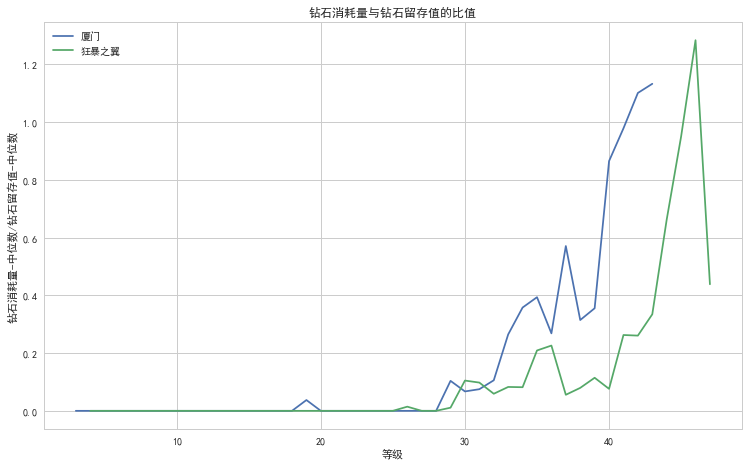

In [112]:
# fig = plt.figure()

# fig, ax = plt.subplots()

# ax = fig.add_subplot(111)
# ax.plot(res.loc[res['Level']<=30,'指标消耗量-中位数']/res.loc[res['Level']<=30,'指标留存值-中位数'])#绘制线
# ax.plot(kuangbao.loc[kuangbao['Level']<=30,'指标消耗量-中位数']/kuangbao.loc[kuangbao['Level']<=30,'指标留存值-中位数'],color='r')

fig, ax = plt.subplots()
# ax.plot(res.loc[res['Level']<=30,'指标消耗量-中位数']/res.loc[res['Level']<=30,'指标留存值-中位数'],label='厦门')#绘制线
# ax.plot(kuangbao.loc[kuangbao['Level']<=30,'指标消耗量-中位数']/kuangbao.loc[kuangbao['Level']<=30,'指标留存值-中位数'],label='狂暴之翼')

ax.plot(res['指标消耗量-中位数']/res['指标留存值-中位数'],label='厦门')
ax.plot(kuangbao['指标消耗量-中位数']/kuangbao['指标留存值-中位数'],label='狂暴之翼')


# Now add the legend with some customizations.
legend = ax.legend(loc='upper left', shadow=True)

ax.set_xlabel("等级")
ax.set_ylabel("钻石消耗量-中位数/钻石留存值-中位数")
ax.set_title("钻石消耗量与钻石留存值的比值")

# ax.set
fig.set_size_inches(12.5, 7.5, forward=True)
fig.savefig('钻石消耗量对比.png', dpi=1000)
fig.show()

In [105]:
type(ax)

matplotlib.axes._subplots.AxesSubplot

/home/maoan/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


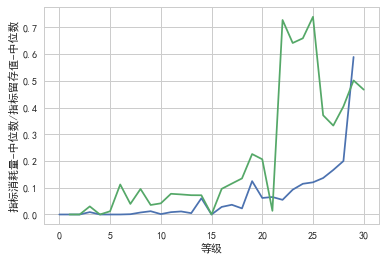

In [101]:
# fig, ax1 = plt.subplots()
# ax2 = ax1.twinx()


# plt.plot(res['指标消耗量-中位数'])
# plt.plot(res['指标留存值-中位数'])
# fig =plt.figure()
# ax = fig.add_subplot(111)
plt.plot(res.loc[res['Level']<=30,'指标消耗量-中位数']/res.loc[res['Level']<=30,'指标留存值-中位数'])
plt.plot(kuangbao.loc[kuangbao['Level']<=30,'指标消耗量-中位数']/kuangbao.loc[kuangbao['Level']<=30,'指标留存值-中位数'])
plt.ylabel("指标消耗量-中位数/指标留存值-中位数")
plt.xlabel("等级")
plt.legend(loc='upper left')
plt.savefig('myfig.png',)


### 金币变化与时间的关系

In [15]:
def keyIndexChangeByTime(sqlstr, db, interval_in_secs):

    data_iterator = dataGen(db, sqlstr)

    current_player = -1
    current_level = -1

    increase_times = 0
    increase_vol = 0
    decrease_times = 0
    decrease_vol = 0
    zhanli_increase_times = 0
    zhanli_increase_vol = 0

    last_status = -1
    last_zhanli = -1
    last_key_factor = -1

    time_limit = 300
    time_interval = 0

    key_factor_dict = collections.defaultdict(list)

    # action_contribution_dict = collections.defaultdict(list)

    counter = 0

    for row in data_iterator:
        counter += 1
        if counter % 1000000 == 0:
            print("%s lines processed\n" % counter)
            # print(timestamp)

        player_id = row[0]
        timestamp = row[1]
        key_factor = row[2]
        zhanli = row[3]

        # 如果更换用户，初始化所有值
        if player_id != current_player:


            first_action_time = timestamp
            last_action_time = timestamp
            one_block_time = 0

            ##忽略最后不满一小时的数据
            # player_list.append(last_key_value)

            # if current_player != -1:

            increase_times = 0
            increase_vol = 0
            decrease_times = 0
            decrease_vol = 0
            zhanli_increase_times = 0
            zhanli_increase_vol = 0

            last_key_factor = key_factor
            last_zhanli = zhanli
            time_interval = 0

            current_player = player_id

        # if major_action == None or major_action == "启动":
        #     continue

        if timestamp - last_action_time <= time_limit:
            during_time = last_action_time - first_action_time
            if during_time + one_block_time >= interval_in_secs:
                time_interval += 1
                key_factor_dict[time_interval].append(
                    (increase_times, increase_vol, decrease_times, decrease_vol, last_key_factor,
                     zhanli_increase_times, zhanli_increase_vol, last_zhanli))

                increase_times = 0
                increase_vol = 0
                decrease_times = 0
                decrease_vol = 0
                zhanli_increase_times = 0
                zhanli_increase_vol = 0

                last_zhanli = zhanli
                last_key_factor = key_factor
                first_action_time = timestamp
                one_block_time = 0
                continue


        else:
            one_block_time += last_action_time - first_action_time
            first_action_time = timestamp

        ## 如果关键指标增长了，记录增长量以及增长次数。
        if key_factor - last_key_factor > 0:
            diff = key_factor - last_key_factor
            increase_times += 1
            increase_vol += diff
        elif key_factor - last_key_factor < 0:
            diff = last_key_factor - key_factor
            decrease_times += 1
            decrease_vol += diff

        if zhanli - last_zhanli > 0:
            diff = zhanli - last_zhanli
            zhanli_increase_times += 1
            zhanli_increase_vol += diff


        last_action_time = timestamp
        last_key_factor = key_factor
        last_zhanli = zhanli

    names = "时间段－"+ str(interval_in_secs) + "s"
    pd_dist = pd.DataFrame(list(key_factor_dict.items()), columns=[names, 'KeyFactor'])
    
    pd_dist['人数'] = pd_dist['KeyFactor'].apply(lambda x: len(x))
    pd_dist['指标增加次数-中位数'] = pd_dist['KeyFactor'].apply(lambda x: np.median([e[0] for e in x]))
    pd_dist['指标增加次数-平均数'] = pd_dist['KeyFactor'].apply(lambda x: np.mean([e[0] for e in x]))
    pd_dist['指标增加量-中位数'] = pd_dist['KeyFactor'].apply(lambda x: np.median([e[1] for e in x]))
    pd_dist['指标增加量-平均数'] = pd_dist['KeyFactor'].apply(lambda x: np.median([e[1] for e in x]))
    pd_dist['指标消耗次数-中位数'] = pd_dist['KeyFactor'].apply(lambda x: np.median([e[2] for e in x]))
    pd_dist['指标消耗次数-平均数'] = pd_dist['KeyFactor'].apply(lambda x: np.mean([e[2] for e in x]))
    pd_dist['指标消耗量-中位数'] = pd_dist['KeyFactor'].apply(lambda x: np.median([e[3] for e in x]))
    pd_dist['指标消耗量-平均数'] = pd_dist['KeyFactor'].apply(lambda x: np.mean([e[3] for e in x]))
    pd_dist['指标留存值-中位数'] = pd_dist['KeyFactor'].apply(lambda x: np.median([e[4] for e in x]))
    pd_dist['指标留存值-平均数'] = pd_dist['KeyFactor'].apply(lambda x: np.mean([e[4] for e in x]))
    
    pd_dist['战力提升次数-中位数'] = pd_dist['KeyFactor'].apply(lambda x: np.median([e[5] for e in x]))
    pd_dist['战力提升次数-平均数'] = pd_dist['KeyFactor'].apply(lambda x: np.mean([e[5] for e in x]))
    pd_dist['战力提升量-中位数'] = pd_dist['KeyFactor'].apply(lambda x: np.median([e[6] for e in x]))
    pd_dist['战力提升量-平均数'] = pd_dist['KeyFactor'].apply(lambda x: np.mean([e[6] for e in x]))
    pd_dist['战力值-中位数'] = pd_dist['KeyFactor'].apply(lambda x: np.median([e[7] for e in x]))
    pd_dist['战力值-平均数'] = pd_dist['KeyFactor'].apply(lambda x: np.mean([e[7] for e in x]))
    
    pd_dist.drop("KeyFactor", axis = 1).to_excel("金币随时间变化情况.xlsx", 'Sheet1',index=False, engine='xlsxwriter')
    
    return pd_dist


In [16]:
sqls = "SELECT yonghu_id, timestamp, jinbi, duiwu_zhanli FROM maidian WHERE num_days_played > 1 ORDER BY yonghu_id,duiwu_level ASC;"
# res = keyIndexChangeByLevel()
res = keyIndexChangeByTime(sqlstr=sqls,db=db4,interval_in_secs=600)

1000000 lines processed

2000000 lines processed

3000000 lines processed

4000000 lines processed

5000000 lines processed

6000000 lines processed



In [17]:
res

,时间段－600s,KeyFactor,人数,指标增加次数-中位数,指标增加次数-平均数,指标增加量-中位数,指标增加量-平均数,指标消耗次数-中位数,指标消耗次数-平均数,指标消耗量-中位数,指标消耗量-平均数,指标留存值-中位数,指标留存值-平均数,战力提升次数-中位数,战力提升次数-平均数,战力提升量-中位数,战力提升量-平均数,战力值-中位数,战力值-平均数
0,1,"[(5, 61414, 1, 1000, 110414, 6, 3409, 6601), (...",1567,5.0,5.449266,63880.0,63880.0,0.0,0.382897,0.0,1982.917677,112884.0,3.162608e+05,4.0,4.616465,2771.0,2667.188258,6080.0,5915.065731
1,2,"[(13, 1035401, 2, 4356, 1141459, 9, 7030, 1363...",1492,7.0,7.768767,255891.5,255891.5,1.0,1.522788,1000.0,5092.958445,953803.5,7.759753e+05,5.0,5.158177,3531.0,4065.195710,8855.0,10005.234584
2,3,"[(5, 155387, 2, 4630, 1292216, 3, 2260, 15891)...",1423,5.0,5.334505,165985.0,165985.0,1.0,9.130710,1000.0,5639.246662,1174314.0,1.070340e+06,4.0,3.900211,4269.0,3934.492621,13429.0,13952.239635
3,4,"[(4, 171103, 67, 45936, 1417383, 4, 4367, 2025...",1347,4.0,4.746102,147478.0,147478.0,12.0,26.104677,9125.0,15791.586488,1318777.0,1.249651e+06,3.0,2.952487,2794.0,3107.982925,17011.0,17081.983667
4,5,"[(7, 155168, 11, 10834, 1561717, 2, 841, 21099...",1277,4.0,4.622553,118469.0,118469.0,16.0,27.317150,15897.0,22642.537980,1439324.0,1.388014e+06,2.0,2.371966,2171.0,2648.997651,19391.0,19759.283477
5,6,"[(3, 17822, 7, 12550, 1566989, 1, 601, 21700),...",1216,4.0,4.567434,91205.5,91205.5,12.0,19.936678,14125.0,26794.048520,1526607.0,1.495642e+06,2.0,2.134046,1603.5,2223.840461,21073.0,21957.503289
6,7,"[(5, 78887, 8, 14394, 1631482, 3, 569, 22269),...",1155,4.0,4.343723,73842.0,73842.0,11.0,17.853680,16125.0,35743.353247,1582448.0,1.582832e+06,2.0,2.061472,1281.0,2163.016450,22490.0,24093.691775
7,8,"[(5, 152640, 34, 102424, 1681698, 3, 6895, 291...",1086,4.0,4.695212,74856.0,74856.0,10.0,18.214549,17658.0,55040.636280,1629079.5,1.652793e+06,2.0,2.118785,1260.0,2702.431860,26210.5,26808.955801
8,9,"[(5, 149821, 42, 26470, 1805049, 4, 7144, 3630...",1031,4.0,4.905917,83444.0,83444.0,12.0,20.652764,26621.0,62784.189137,1682101.0,1.733580e+06,2.0,2.065955,1606.0,2957.591659,28820.0,29751.982541
9,10,"[(3, 92000, 10, 41210, 1855839, 1, 582, 36890)...",971,4.0,5.147271,98016.0,98016.0,14.0,22.064882,34789.0,65794.836251,1746308.0,1.834108e+06,2.0,2.056643,1756.0,3289.880536,31563.0,33128.176107


In [35]:
from sklearn import preprocessing
X = np.array([[ 1., -1.,  2.],
               [ 2.,  0.,  0.],
             [ 0.,  1., -1.]])
scaler = preprocessing.StandardScaler().fit(X)

In [54]:
y=np.array([1,2,3])

In [61]:
r = np.random.permutation(len(y))

In [62]:
r

array([1, 2, 0])

In [64]:
X[r]

array([[ 2.,  0.,  0.],
       [ 0.,  1., -1.],
       [ 1., -1.,  2.]])

In [33]:
ranks = [str(n) for n in range(2, 11)] + list('JQKA')

In [32]:
suits = 'spades diamonds clubs hearts'.split()

In [5]:
import os
aa, filename = os.path.split('/home/luciano/.ssh/idrsa.pub')

In [4]:
filename

'idrsa.pub'

In [11]:
 key_factor_dict = collections.defaultdict(list)

In [16]:
key_factor_dict[1].append((3,45))


In [17]:
key_factor_dict[1]

[(3, 45), (3, 45)]

In [2]:
def empirical_covariance(X, assume_centered=False):
    """Computes the Maximum likelihood covariance estimator
    Parameters
    ----------
    X : ndarray, shape (n_samples, n_features)
        Data from which to compute the covariance estimate
    assume_centered : Boolean
        If True, data are not centered before computation.
        Useful when working with data whose mean is almost, but not exactly
        zero.
        If False, data are centered before computation.
    Returns
    -------
    covariance : 2D ndarray, shape (n_features, n_features)
        Empirical covariance (Maximum Likelihood Estimator).
    """
    X = np.asarray(X)
    if X.ndim == 1:
        X = np.reshape(X, (1, -1))

    if X.shape[0] == 1:
        warnings.warn("Only one sample available. "
                      "You may want to reshape your data array")

    if assume_centered:
        covariance = np.dot(X.T, X) / X.shape[0]
    else:
        covariance = np.cov(X.T, bias=1)

    if covariance.ndim == 0:
        covariance = np.array([[covariance]])
    return covariance

In [3]:
x = [[1,2,3],[4,5,6],[7,8,9]]

In [4]:
test = np.array(x)

In [11]:
np.cov(test.T,bias=1)

array([[ 6.,  6.,  6.],
       [ 6.,  6.,  6.],
       [ 6.,  6.,  6.]])

In [31]:
labels_pred = np.array(labels_pred)

In [32]:
labels_pred

array([1, 1, 0, 0, 2, 2, 2, 2])

In [19]:
x = np.arange(9.).reshape(3, 3)

In [33]:
np.where(labels_pred ==1., 0, 1)

array([0, 0, 1, 1, 1, 1, 1, 1])

In [34]:
from scipy.cluster.hierarchy import dendrogram, linkage

from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

(150, 2)


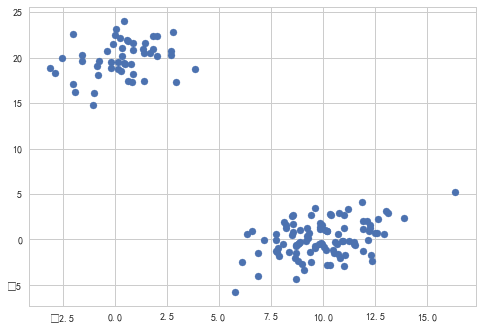

In [36]:
np.random.seed(4711)  # for repeatability of this tutorial
a = np.random.multivariate_normal([10, 0], [[3, 1], [1, 4]], size=[100,])
b = np.random.multivariate_normal([0, 20], [[3, 1], [1, 4]], size=[50,])
X = np.concatenate((a, b),)
print(X.shape)  # 150 samples with 2 dimensions
plt.scatter(X[:,0], X[:,1])
plt.show()

In [38]:
Z = linkage(X, 'ward')

In [42]:
Z

array([[  5.20000000e+01,   5.30000000e+01,   4.15105485e-02,
          2.00000000e+00],
       [  1.40000000e+01,   7.90000000e+01,   5.91375926e-02,
          2.00000000e+00],
       [  3.30000000e+01,   6.80000000e+01,   7.10677929e-02,
          2.00000000e+00],
       [  1.70000000e+01,   7.30000000e+01,   7.13712071e-02,
          2.00000000e+00],
       [  1.00000000e+00,   8.00000000e+00,   7.54313099e-02,
          2.00000000e+00],
       [  8.50000000e+01,   9.50000000e+01,   1.09277896e-01,
          2.00000000e+00],
       [  1.08000000e+02,   1.31000000e+02,   1.10071548e-01,
          2.00000000e+00],
       [  9.00000000e+00,   6.60000000e+01,   1.13022407e-01,
          2.00000000e+00],
       [  1.50000000e+01,   6.90000000e+01,   1.14289714e-01,
          2.00000000e+00],
       [  6.30000000e+01,   9.80000000e+01,   1.21200766e-01,
          2.00000000e+00],
       [  1.07000000e+02,   1.15000000e+02,   1.21671017e-01,
          2.00000000e+00],
       [  6.50000000e

In [55]:
X

array([[  9.21188389e+00,  -1.51885892e-01],
       [  8.88937431e+00,  -3.39374638e-01],
       [  1.07684006e+01,   2.95244645e+00],
       [  8.24213268e+00,   1.29094802e+00],
       [  5.79670090e+00,  -5.83776714e+00],
       [  6.34993090e+00,   6.39595151e-01],
       [  8.10571230e+00,  -4.58872773e-01],
       [  8.72084884e+00,  -4.40444487e+00],
       [  8.83500513e+00,  -3.91661101e-01],
       [  1.04006121e+01,   2.71240817e+00],
       [  1.19550340e+01,   1.98602715e+00],
       [  8.50141850e+00,   5.03495832e-01],
       [  9.23359190e+00,   1.30693205e+00],
       [  1.22776800e+01,   1.62763958e+00],
       [  1.09590184e+01,  -1.27520318e-01],
       [  8.72437412e+00,  -7.31019114e-01],
       [  9.64949127e+00,   3.41989410e+00],
       [  1.14991208e+01,  -5.51131721e-01],
       [  1.14825643e+01,  -2.86234942e-01],
       [  8.58740424e+00,   1.66814229e+00],
       [  1.19557043e+01,  -1.27350693e+00],
       [  9.85622312e+00,   1.08989137e+00],
       [  

In [ ]:
fe

In [65]:
''.join([' {:^15} |'] * 4).format(*features)

'    Duration     |      Freq       |    FirstTime    |    TimeOnUI     |'

____

In [3]:
profile = pd.read_csv("/home/maoan/maidianAnalysis/level2-uianalysis/userFile_vip.csv")

In [6]:
profile.loc[profile['stay']].drop("stay",axis=1).to_csv("userProfile.csv",index=False)

In [25]:
def binarySearch(sArr, key):
    begin = 0
    end = len(sArr) - 1

    while begin <= end:
        loc = -1
        mid = begin + (end - begin)//2

        if sArr[mid] > key:
            end = mid -1
        elif sArr[mid] < key:
            begin = mid +1
        else:
            return mid

    return loc

In [26]:
binarySearch([1,2,3,4,5,7],7)

5

In [21]:
(4-1)//2

1

In [27]:
a = [2,5,23,2,5,66,4]

In [29]:
sorted(a)

[2, 2, 4, 5, 5, 23, 66]

In [30]:
a

[2, 5, 23, 2, 5, 66, 4]

In [63]:
wp = pd.Panel(randn(2, 5, 4), items=['Item1', 'Item2'],
              major_axis=pd.date_range('1/1/2000', periods=5),
              minor_axis=['A', 'B', 'C', 'D'])

NameError: name 'randn' is not defined

In [64]:
pd.date_range('1/1/2000', periods=5)

DatetimeIndex(['2000-01-01', '2000-01-02', '2000-01-03', '2000-01-04',
               '2000-01-05'],
              dtype='datetime64[ns]', freq='D')